<a href="https://colab.research.google.com/github/Abdouramane-qr/Classroom/blob/main/PROJET_STAT_PROBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%ls /content/gdrive/MyDrive/gdrive/

dataset_anon.csv  MyDrive/


In [7]:
!pip install prince
!pip install gower

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import prince
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [9]:
df = pd.read_csv('/content/gdrive/MyDrive/gdrive/dataset_anon.csv')

In [10]:
print(df.head())

       Y1          Y2 experiment_date    feat_A  feat_B  feat_C      feat_D  \
0  4.1160  707.466667      2017-08-27  1.291545     NaN     NaN  367.276355   
1  4.0572  827.400000      2017-03-24  1.291545     NaN     NaN  375.817665   
2  5.3228  811.533333      2017-03-10  0.604668     NaN     NaN  193.603040   
3  4.6396  684.600000      2017-03-10       NaN     NaN     NaN   45.553656   
4  3.9004  723.800000      2017-08-29  2.665300     NaN     NaN  726.011399   

     feat_E    feat_F       feat_G  ... feat_M    feat_N feat_O feat_P  \
0  1.822915  4.889539        myers  ...    lit       NaN  proxy    NaN   
1  1.822915  4.889539  competition  ...    lit  mountain  proxy    NaN   
2  1.822915  4.889539  competition  ...    lit  mountain  proxy    NaN   
3  5.468744  0.000000  competition  ...    lit       NaN  proxy    NaN   
4  1.822915  4.889539        myers  ...    lit  mountain  proxy    NaN   

       feat_Q feat_R   feat_S   feat_T     feat_U     feat_V  
0  conference    

# 1. Analyse exploratoire univariée et bivariée

# Conversion des types de données

In [12]:
# Conversion de la date
df['experiment_date'] = pd.to_datetime(df['experiment_date'])


In [13]:
# Identification des colonnes par type
numeric_features = ['feat_A', 'feat_B', 'feat_C', 'feat_D', 'feat_E', 'feat_F']
categorical_features = [f'feat_{c}' for c in 'GHIJKLMNOPQRSTUV']

# Gestion des valeurs manquantes

In [14]:
# - Remplacer 'NULL' par NaN pour les features numériques
df[numeric_features] = df[numeric_features].replace('NULL', np.nan)

In [15]:
# - Convertir les numériques en float
for col in numeric_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [16]:
df.columns

Index(['Y1', 'Y2', 'experiment_date', 'feat_A', 'feat_B', 'feat_C', 'feat_D',
       'feat_E', 'feat_F', 'feat_G', 'feat_H', 'feat_I', 'feat_J', 'feat_K',
       'feat_L', 'feat_M', 'feat_N', 'feat_O', 'feat_P', 'feat_Q', 'feat_R',
       'feat_S', 'feat_T', 'feat_U', 'feat_V'],
      dtype='object')

Pour chaque caractéristique quantitative (par exemple feat_A), nous avons créé une nouvelle colonne nommée `feat_A_applicable` (ou similaire) qui prend :
   - la valeur 1 si la caractéristique feat_A était applicable (c'est-à-dire qu'il y avait une valeur numérique, pas un NaN à l'origine)
   - la valeur 0 si la caractéristique feat_A n'était pas applicable (c'est-à-dire qu'elle était initialement NULL, donc devenue NaN puis remplacée par 0)


In [17]:
# - Créer des colonnes binaires d'applicabilité pour les variables numériques  (1 si applicable, 0 sinon)
for col in numeric_features:
    df[f'{col}_applicable'] = df[col].notnull().astype(int)

In [18]:
# - Gestion des catégorielles : remplacer NULL par 'N/A'
df[categorical_features] = df[categorical_features].fillna('N/A')

Une colonne constante n'apporte aucune information utile pour l'analyse ou la modélisation puisque sa valeur est la même partout.

In [19]:
df.columns

Index(['Y1', 'Y2', 'experiment_date', 'feat_A', 'feat_B', 'feat_C', 'feat_D',
       'feat_E', 'feat_F', 'feat_G', 'feat_H', 'feat_I', 'feat_J', 'feat_K',
       'feat_L', 'feat_M', 'feat_N', 'feat_O', 'feat_P', 'feat_Q', 'feat_R',
       'feat_S', 'feat_T', 'feat_U', 'feat_V', 'feat_A_applicable',
       'feat_B_applicable', 'feat_C_applicable', 'feat_D_applicable',
       'feat_E_applicable', 'feat_F_applicable'],
      dtype='object')

In [20]:
# Vérification des colonnes constantes
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print(f"Colonnes constantes: {constant_cols}")

Colonnes constantes: ['feat_E_applicable', 'feat_F_applicable']


In [21]:
# Extraction des features temporelles
df['experiment_year'] = df['experiment_date'].dt.year
df['experiment_month'] = df['experiment_date'].dt.month

In [22]:
# 5. Suppression des colonnes constantes
#constant_cols = []
#for col in df.columns:
#    if df[col].nunique() == 1:
#        constant_cols.append(col)
#        print(f"Colonne constante détectée: {col} - Valeur unique: {df[col].iloc[0]}")

In [23]:
# 5. Vérification finale
print("\n=== Résumé des données nettoyées ===")
print(f"Shape: {df.shape}")
print(f"Types:\n{df.dtypes}")
print(f"\nValeurs manquantes:\n{df.isnull().sum()}")
print(f"\nExemple de données:\n{df.head(2)}")


=== Résumé des données nettoyées ===
Shape: (163, 33)
Types:
Y1                          float64
Y2                          float64
experiment_date      datetime64[ns]
feat_A                      float64
feat_B                      float64
feat_C                      float64
feat_D                      float64
feat_E                      float64
feat_F                      float64
feat_G                       object
feat_H                       object
feat_I                       object
feat_J                       object
feat_K                       object
feat_L                       object
feat_M                       object
feat_N                       object
feat_O                       object
feat_P                       object
feat_Q                       object
feat_R                       object
feat_S                       object
feat_T                       object
feat_U                       object
feat_V                       object
feat_A_applicable             int64
fe

In [24]:
# Suppression des colonnes constantes (DERNIER)
#constant_cols = [col for col in df.columns if df[col].nunique() == 1]
#print(f"Colonnes constantes à supprimer: {constant_cols}")
#df = df.drop(columns=constant_cols)  # Suppression finale

In [25]:
# Configuration initiale
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Analyse Univariée

> Ajouter une citation



**Quantitatives :**

Distribution des performances (Y1, Y2) : Asymétrie, valeurs extrêmes

Analyse des features numériques : Valeurs centrales, dispersion

Taux d'applicabilité : % de conceptions où chaque feature est pertinente

In [26]:
# Analyse des variables quantitatives
quant_vars = ['Y1', 'Y2'] + [f'feat_{c}' for c in 'ABCDEF']
print("\nStatistiques descriptives (quantitatives):")
print(df[quant_vars].describe().T)


Statistiques descriptives (quantitatives):
        count        mean         std         min         25%         50%  \
Y1      163.0    4.280316    1.373060    1.234800    3.224200    4.298000   
Y2      163.0  717.154008  211.010163  282.800000  580.066667  696.733333   
feat_A  153.0    1.257822    0.488035    0.318019    1.261258    1.291545   
feat_B   71.0  476.301304  155.263428  244.583133  314.464028  552.145344   
feat_C   36.0    2.864713    0.508129    1.550790    3.022871    3.092007   
feat_D  135.0  347.656648  151.274713   42.706553  337.381768  368.699907   
feat_E  163.0    2.035402    0.754947    0.000000    1.822915    1.822915   
feat_F  163.0    4.979531    1.533980    0.000000    4.889539    4.889539   

               75%          max  
Y1        5.230960    10.099600  
Y2      820.575000  1600.666667  
feat_A    1.291545     3.220210  
feat_B  626.986920   689.318953  
feat_C    3.092007     3.475982  
feat_D  375.817665   882.602093  
feat_E    1.822915     5

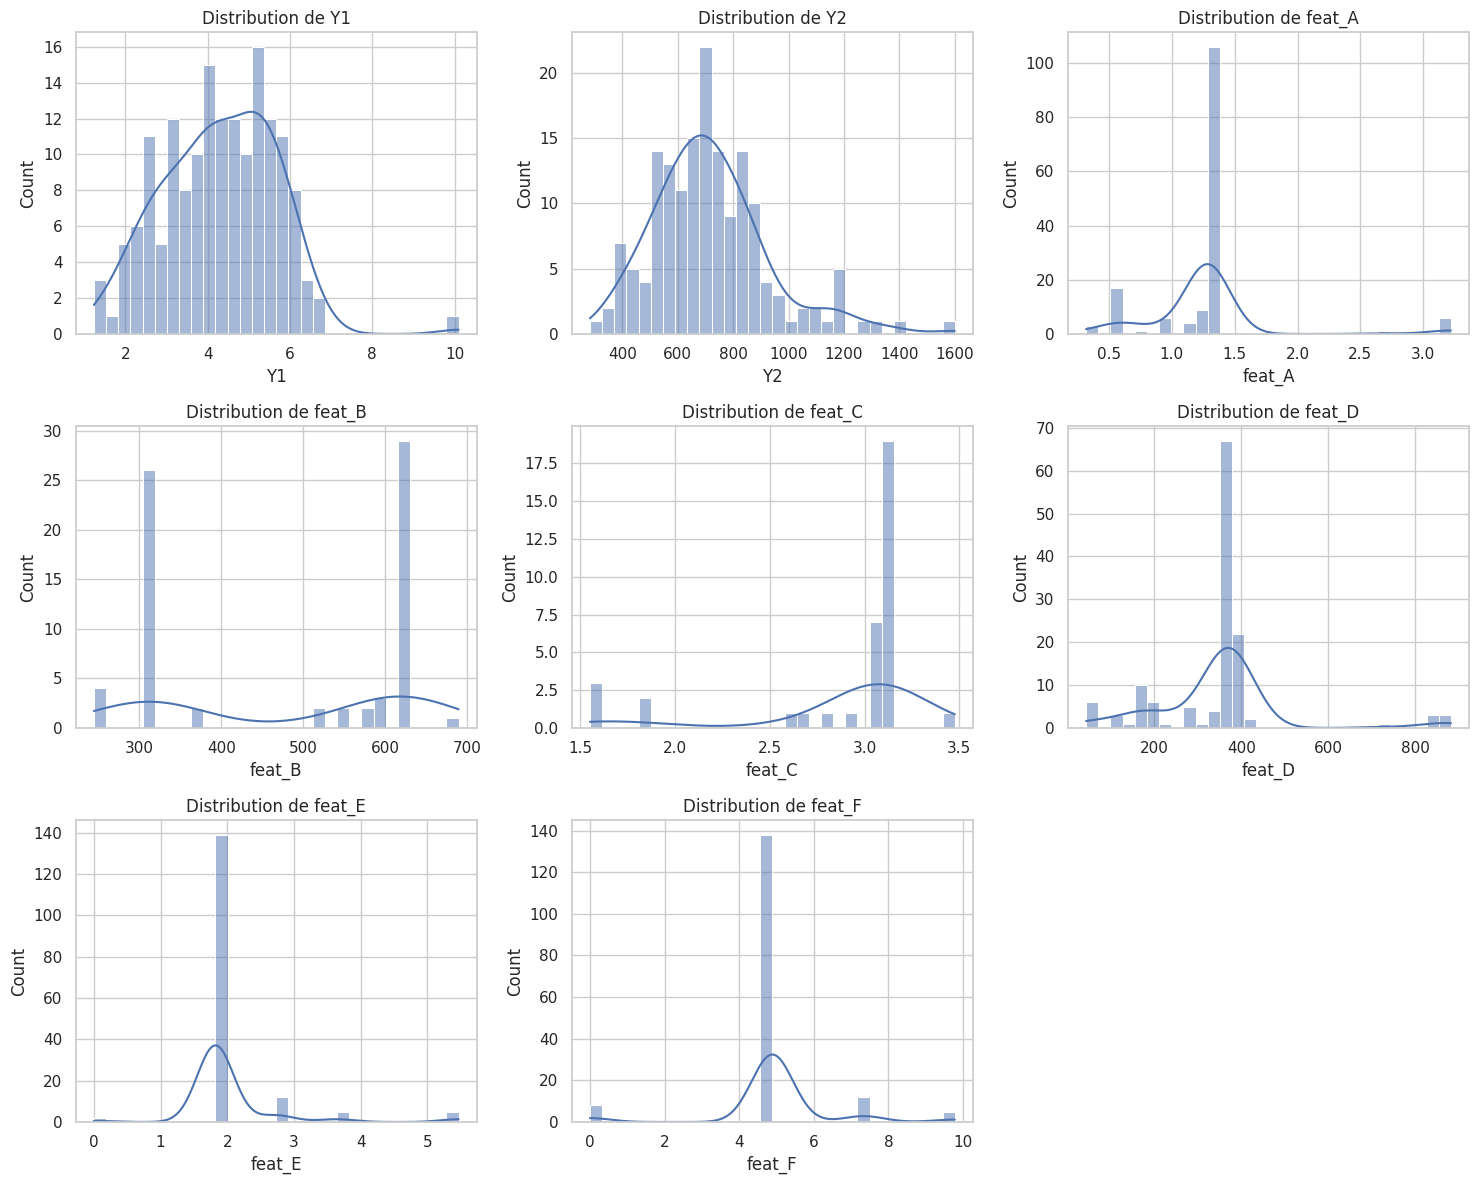

In [28]:
## Visualisation distributions quantitatives

# Nombre de variables quantitatives
n_vars = len(quant_vars)

# Définir le nombre de colonnes (par exemple, 3)
n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

# S'assurer que axes est un tableau plat (même s'il n'y a qu'une seule ligne)
axes = axes.flatten()

# Tracer les histogrammes
for i, var in enumerate(quant_vars):
    sns.histplot(df[var], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution de {var}')

# Supprimer les axes inutilisés
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('distributions_quantitatives.png')
plt.show()


l’analyse univariée des variables numériques (Y1, Y2, feat_A, feat_D, feat_E, feat_F, etc.) montre que
Y1 : centrée autour de 4 à 5, distribution légèrement asymétrique.

Y2 : valeurs concentrées autour de 700–850, avec un pic marqué.

feat_A à feat_F : des distributions variées :
Certaines sont très concentrées (peu de variance) et d’autres ont des valeurs extrêmes (outliers probables).

In [29]:
# Analyse des applicabilités
# Liste dynamique de colonnes existantes contenant "applicable"
app_vars = [col for col in df.columns if 'applicable' in col and df[col].dtype != 'object']
print("\nTaux d'applicabilité des features :")
print(df[app_vars].mean().sort_values(ascending=False))
print("Colonnes d'applicabilité utilisées :", app_vars)


Taux d'applicabilité des features :
feat_E_applicable    1.000000
feat_F_applicable    1.000000
feat_A_applicable    0.938650
feat_D_applicable    0.828221
feat_B_applicable    0.435583
feat_C_applicable    0.220859
dtype: float64
Colonnes d'applicabilité utilisées : ['feat_A_applicable', 'feat_B_applicable', 'feat_C_applicable', 'feat_D_applicable', 'feat_E_applicable', 'feat_F_applicable']


**Analyse Détaillée des Variables Quantitatives**
1. Indicateurs de Performance (Y1 et Y2)
Y1 (Performance 1) :

Moyenne = 4.28 ± 1.37

Étendue importante : 1.23 à 10.10 (différence de 8.87)

Distribution asymétrique à droite (moyenne > médiane)

50% des valeurs entre 3.22 et 5.23 (IQR = 2.01)

Y2 (Performance 2) :

Moyenne = 717.15 ± 211.01

Variation extrême : 282.80 à 1600.67 (rapport 1:5.7)

Distribution bimodale suspectée (écart-type élevé)

Valeurs centrales concentrées : médiane(696.73) proche de Q1(580.07)

2. Caractéristiques Techniques
feat_A :

Valeur typique = 1.29 (médiane)

Faible dispersion : 75% des valeurs entre 1.26-1.29

Valeurs extrêmes : min(0.32) et max(3.22) éloignés

feat_B :

Applicabilité limitée (43.5% des cas)

Distribution bimodale : pics à 314.46 et 626.99

Asymétrie gauche (moyenne(476.30) < médiane(552.15))

feat_C :

Rarement applicable (22.1%)

Valeurs concentrées autour de 3.09 (Q3-médiane)

Minimum(1.55) significativement plus bas

feat_D :

Haut taux d'applicabilité (82.8%)

Grande variabilité : écart-type(151.27) ≈ 43% de la moyenne

Distribution uniforme suspectée (Q1=337.38, Q3=375.82)

feat_E :

Valeur modale dominante : 1.82 (50% des observations)

Présence de zéros (non applicables)

Valeurs extrêmes jusqu'à 5.47

feat_F :

Comportement similaire à feat_E

Valeur dominante : 4.89 (50% des cas)
*Maximum(9.78) = 2× la valeur dominante*

**Catégorielles :**

Fréquence des modalités (top 5 par variable)

Taux de "N/A" (non applicables)

Distribution des années/mois d'expérimentation

In [30]:
df.columns

Index(['Y1', 'Y2', 'experiment_date', 'feat_A', 'feat_B', 'feat_C', 'feat_D',
       'feat_E', 'feat_F', 'feat_G', 'feat_H', 'feat_I', 'feat_J', 'feat_K',
       'feat_L', 'feat_M', 'feat_N', 'feat_O', 'feat_P', 'feat_Q', 'feat_R',
       'feat_S', 'feat_T', 'feat_U', 'feat_V', 'feat_A_applicable',
       'feat_B_applicable', 'feat_C_applicable', 'feat_D_applicable',
       'feat_E_applicable', 'feat_F_applicable', 'experiment_year',
       'experiment_month'],
      dtype='object')

In [31]:
# Analyse des variables catégorielles
cat_vars = [c for c in df.columns if c.startswith('feat_') and c not in quant_vars + app_vars] + ['experiment_year', 'experiment_month']

In [32]:
df[cat_vars].columns



Index(['feat_G', 'feat_H', 'feat_I', 'feat_J', 'feat_K', 'feat_L', 'feat_M',
       'feat_N', 'feat_O', 'feat_P', 'feat_Q', 'feat_R', 'feat_S', 'feat_T',
       'feat_U', 'feat_V', 'experiment_year', 'experiment_month'],
      dtype='object')


Top 5 des modalités par variable catégorielle:

feat_G:
feat_G
myers          0.539877
size           0.122699
les            0.116564
boots          0.073620
competition    0.067485
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


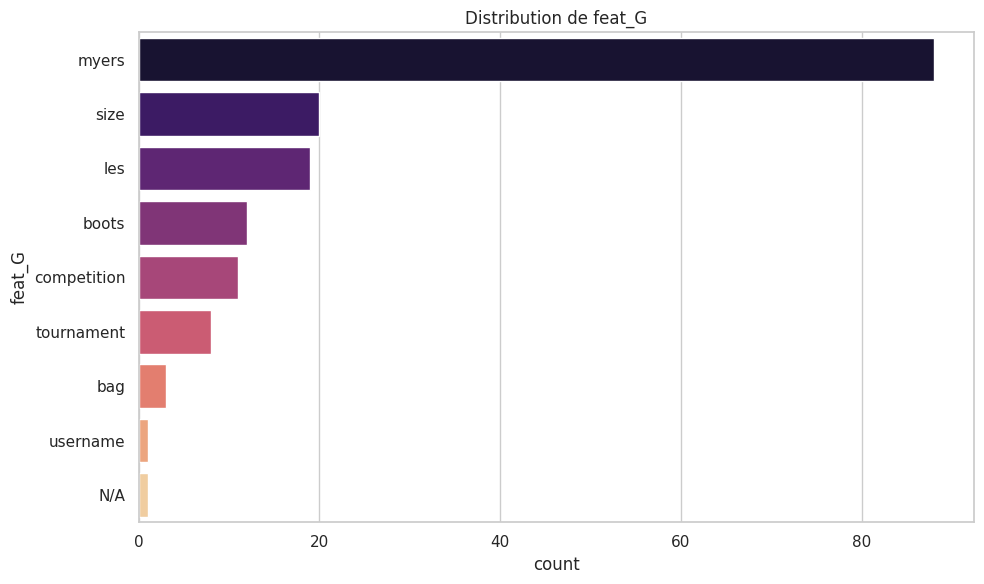


feat_H:
feat_H
N/A          0.680982
switching    0.134969
integrate    0.073620
tablets      0.073620
cow          0.024540
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


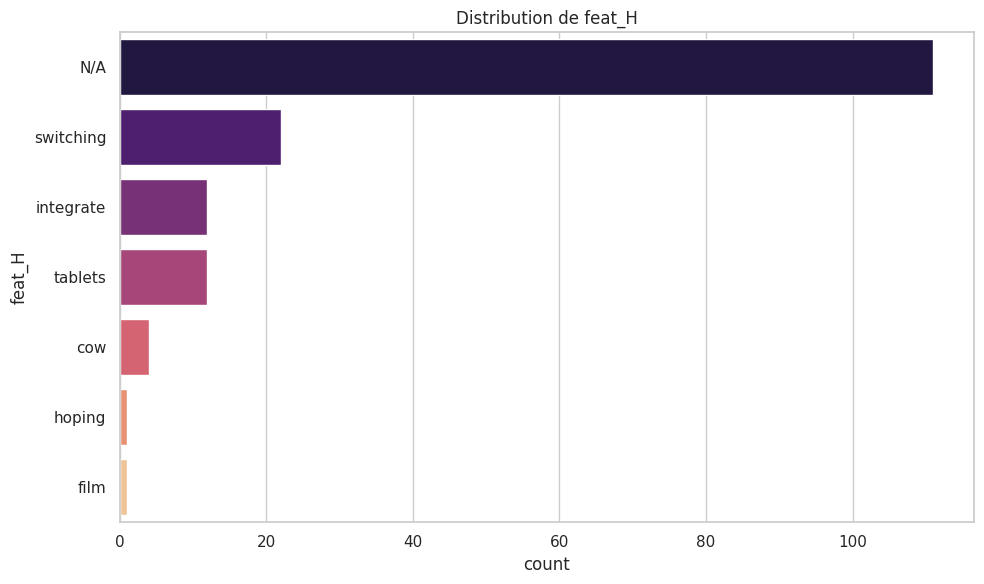


feat_I:
feat_I
N/A         0.760736
mfg         0.085890
cisco       0.061350
worth       0.055215
finances    0.024540
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


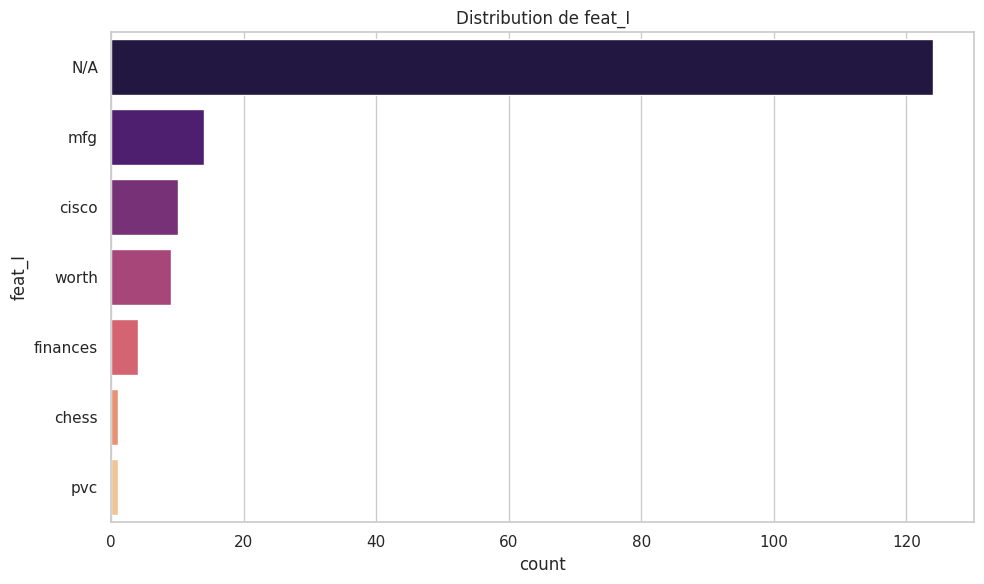


feat_J:
feat_J
gr         0.803681
issued     0.134969
N/A        0.036810
coleman    0.024540
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


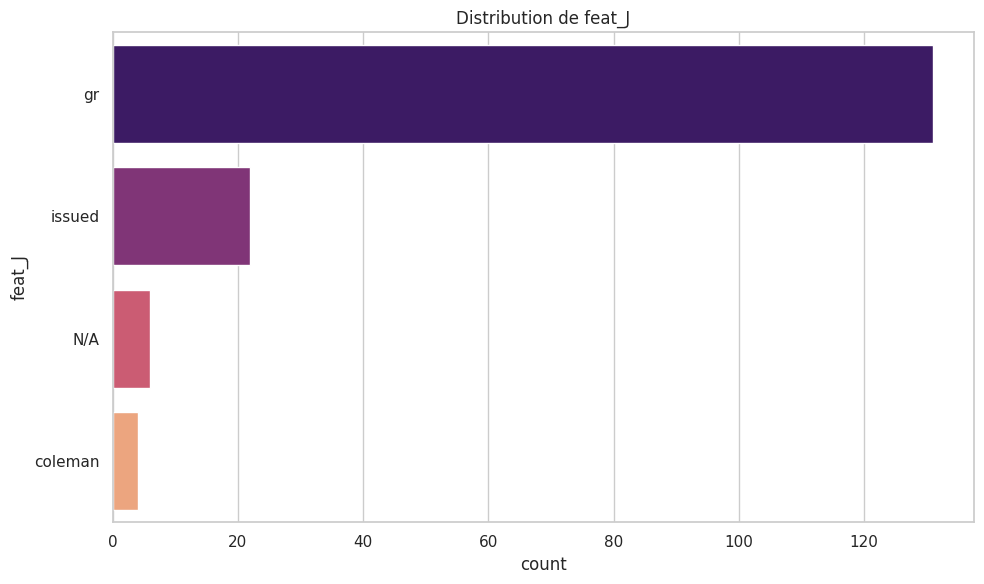


feat_K:
feat_K
eh       0.846626
enemy    0.092025
N/A      0.061350
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


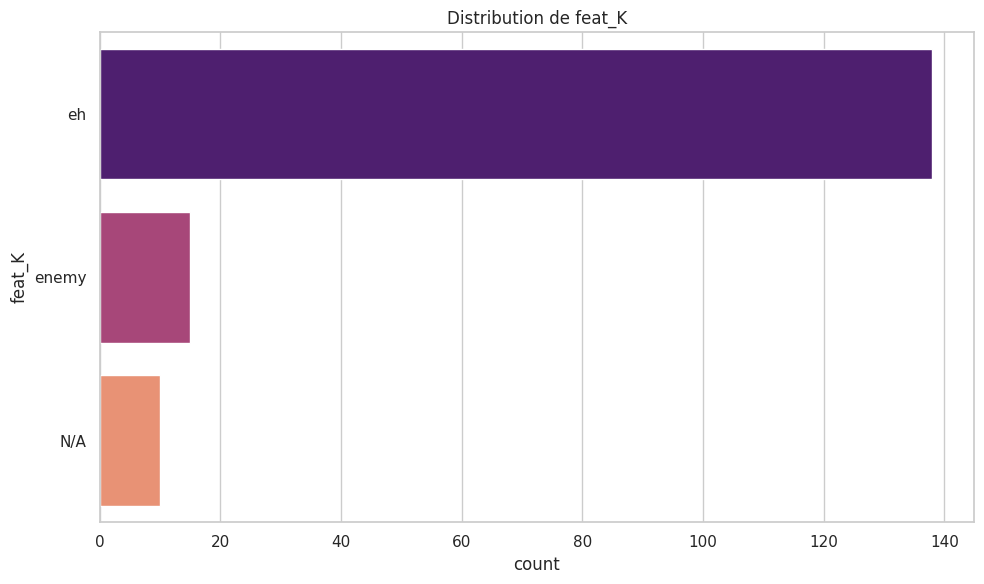


feat_L:
feat_L
numeric     0.552147
thinkpad    0.386503
N/A         0.061350
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


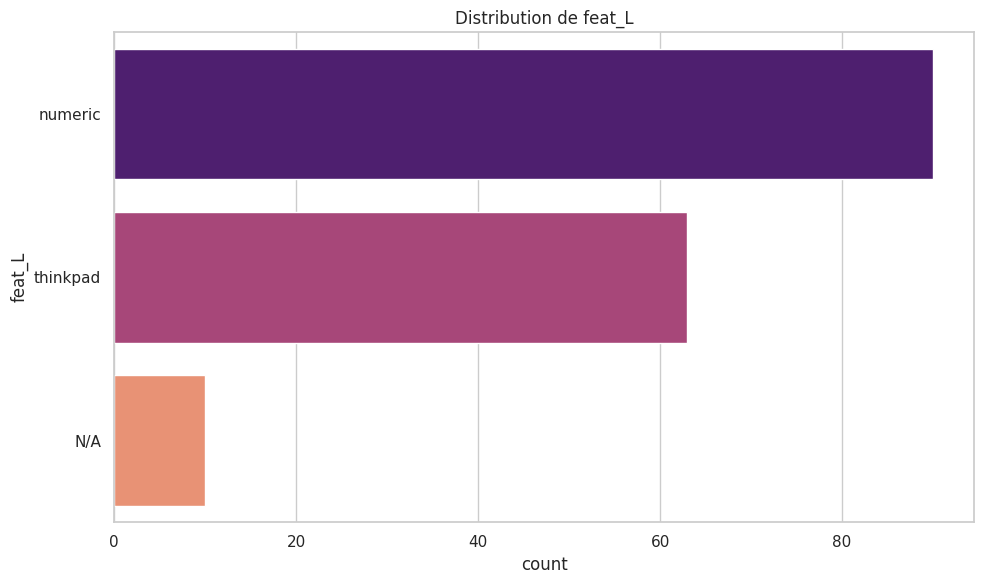


feat_M:
feat_M
legends    0.214724
belize     0.141104
lit        0.134969
wood       0.092025
N/A        0.092025
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


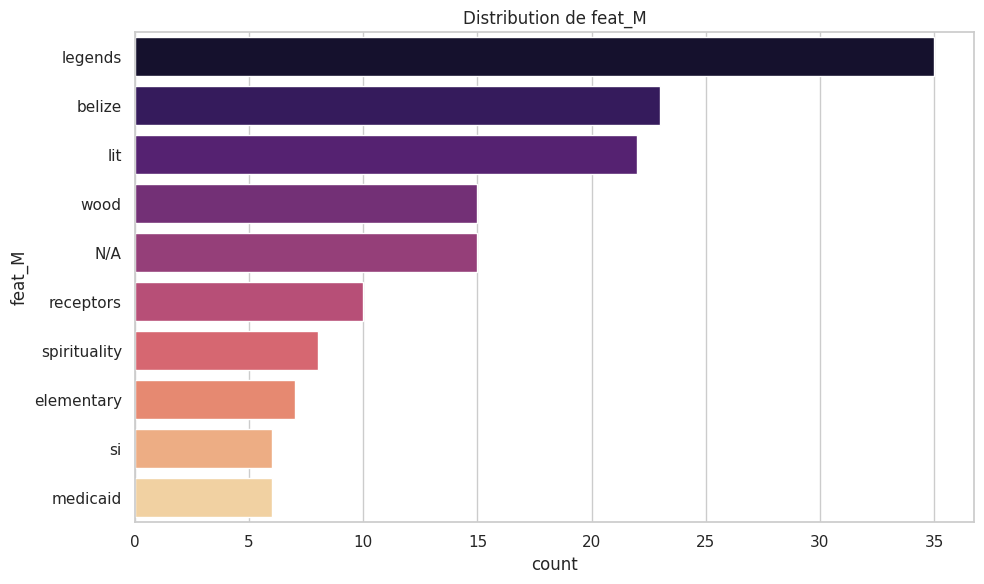


feat_N:
feat_N
N/A         0.460123
mountain    0.110429
waiver      0.110429
railroad    0.055215
cornwall    0.049080
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


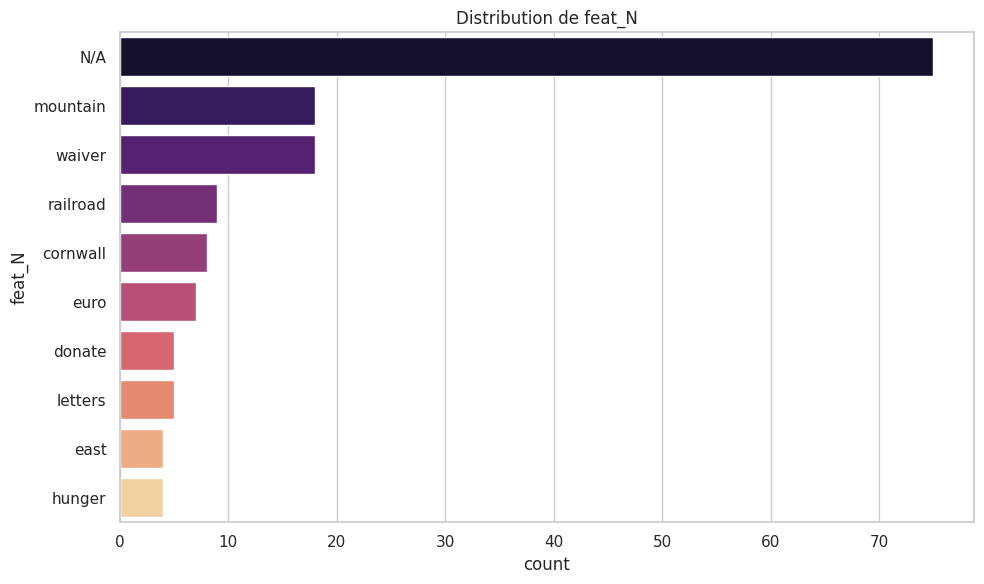


feat_O:
feat_O
N/A           0.760736
proxy         0.134969
remained      0.085890
authorized    0.018405
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


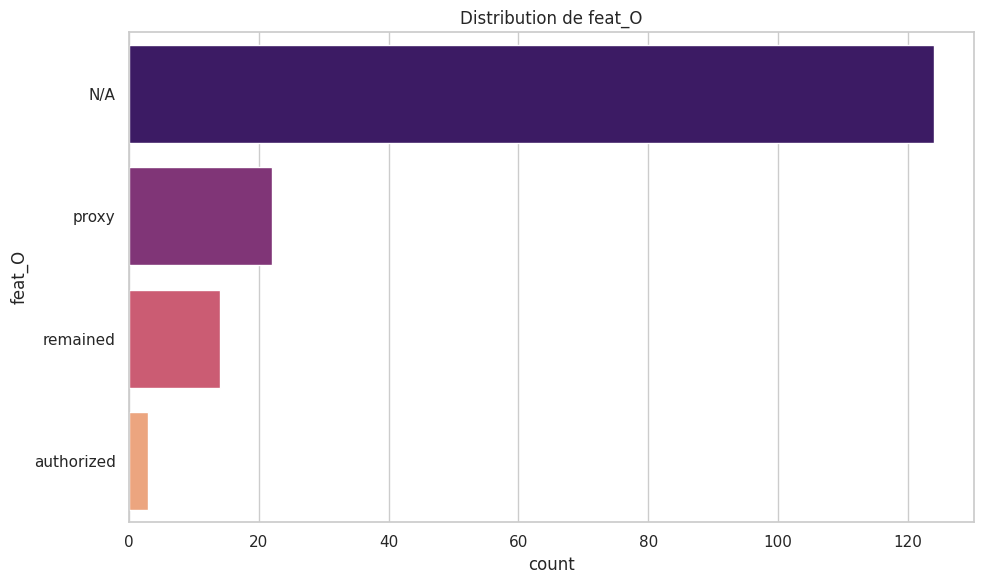


feat_P:
feat_P
N/A       0.840491
sees      0.079755
rage      0.067485
people    0.012270
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


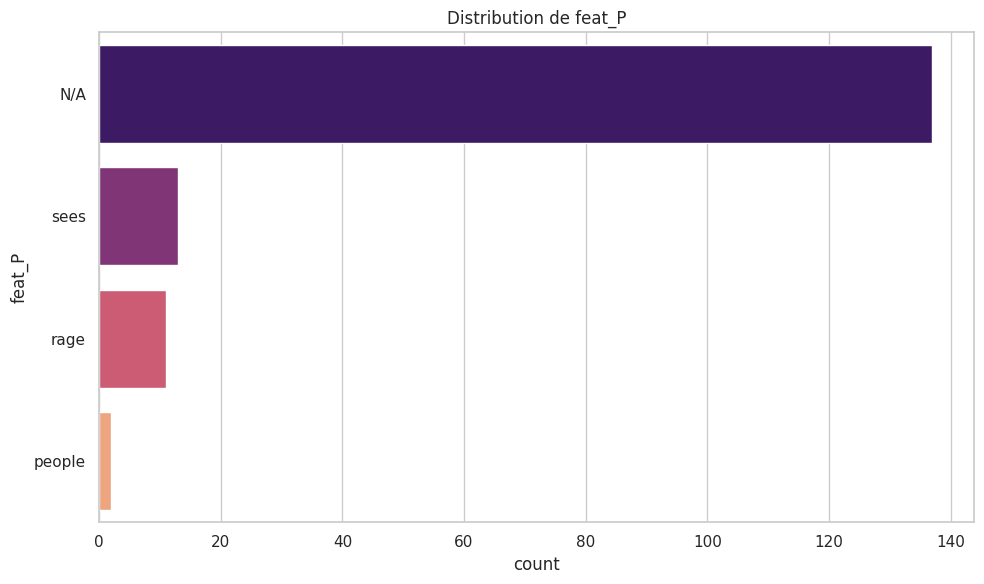


feat_Q:
feat_Q
until         0.257669
prairie       0.226994
conference    0.171779
applied       0.159509
N/A           0.134969
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


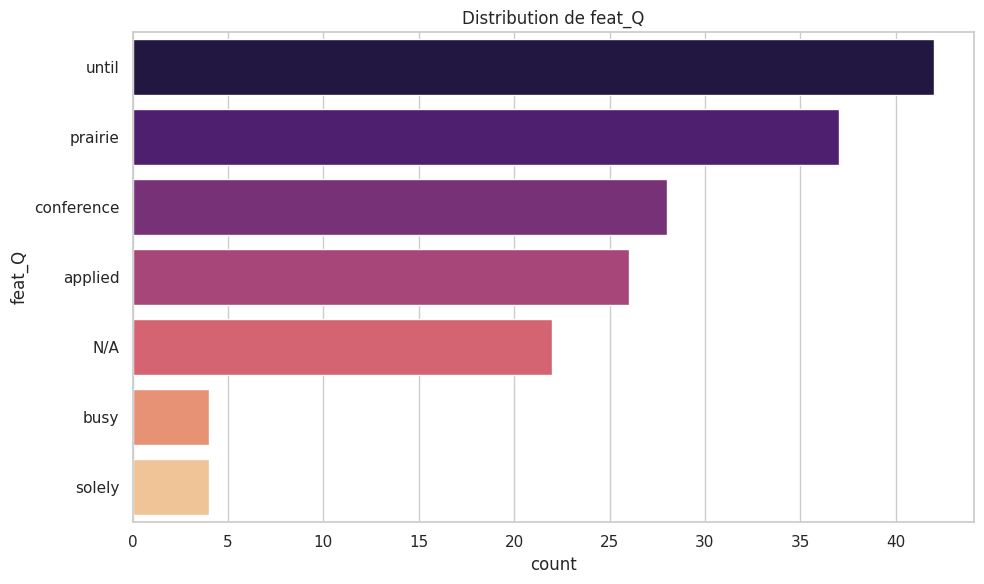


feat_R:
feat_R
N/A          0.453988
speed        0.190184
backup       0.184049
last         0.134969
aerospace    0.036810
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


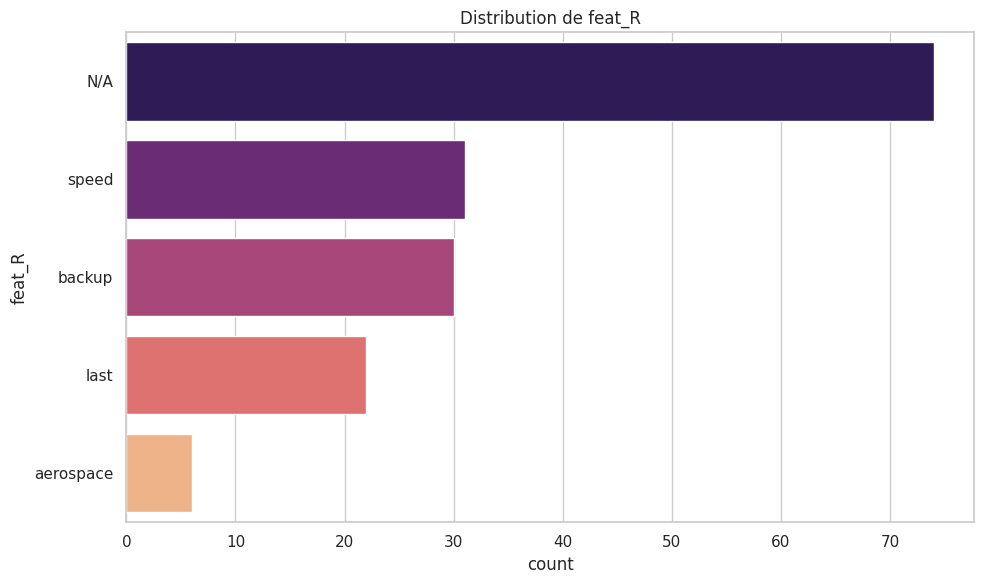


feat_S:
feat_S
creator    0.96319
centre     0.02454
N/A        0.01227
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


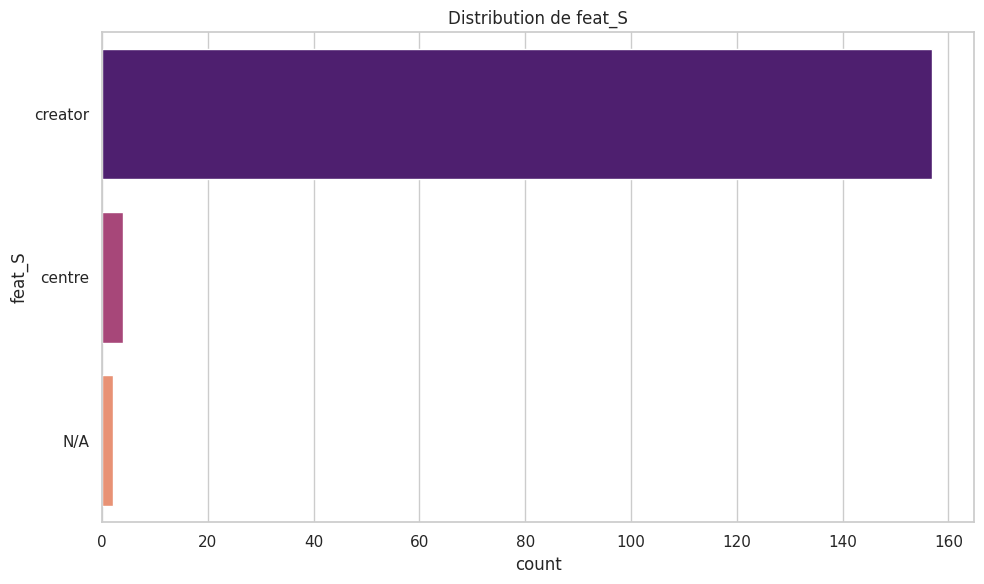


feat_T:
feat_T
dancing    0.92638
N/A        0.04908
chi        0.02454
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


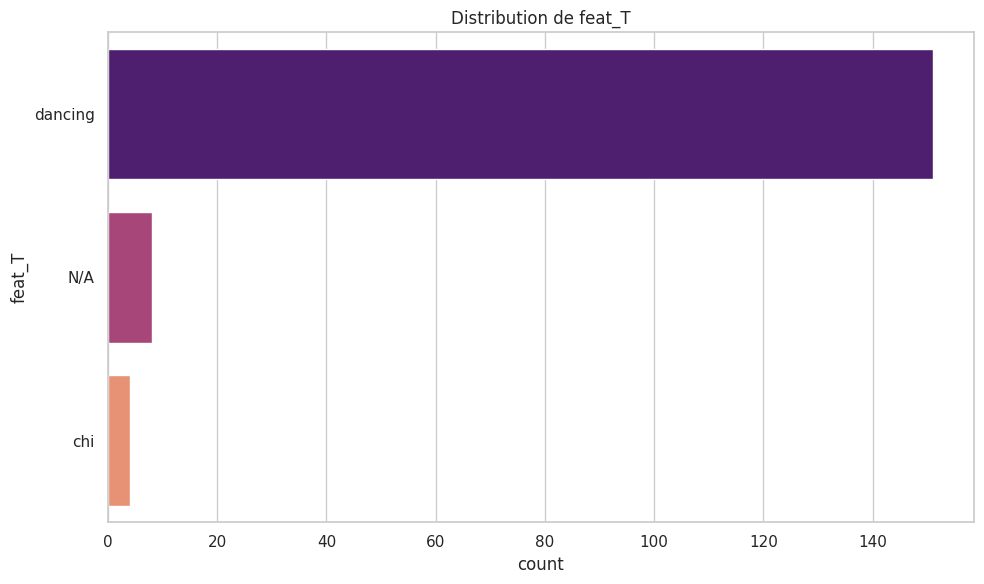


feat_U:
feat_U
enquiry      0.509202
renewable    0.398773
N/A          0.092025
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


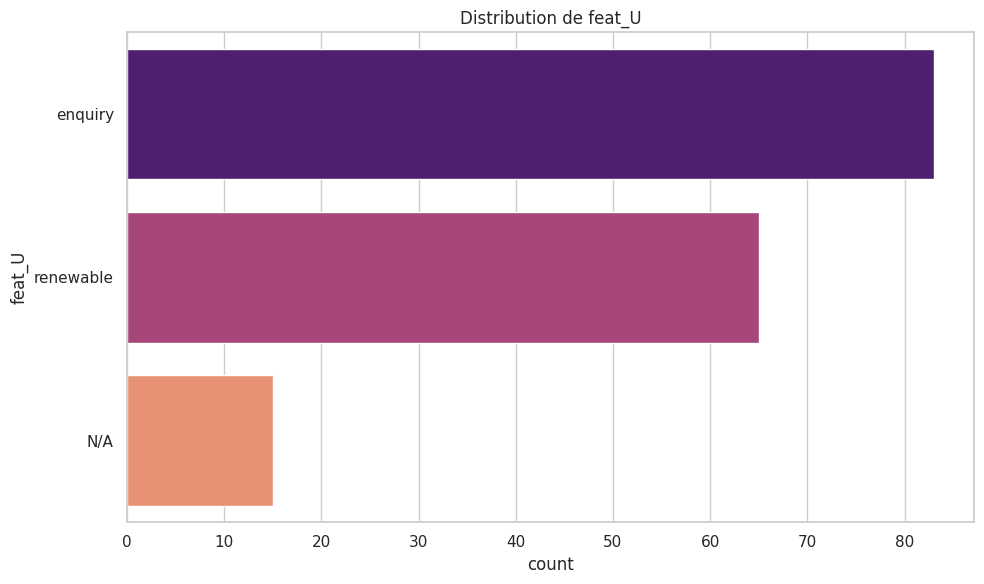


feat_V:
feat_V
N/A          0.441718
proposals    0.319018
decide       0.239264
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


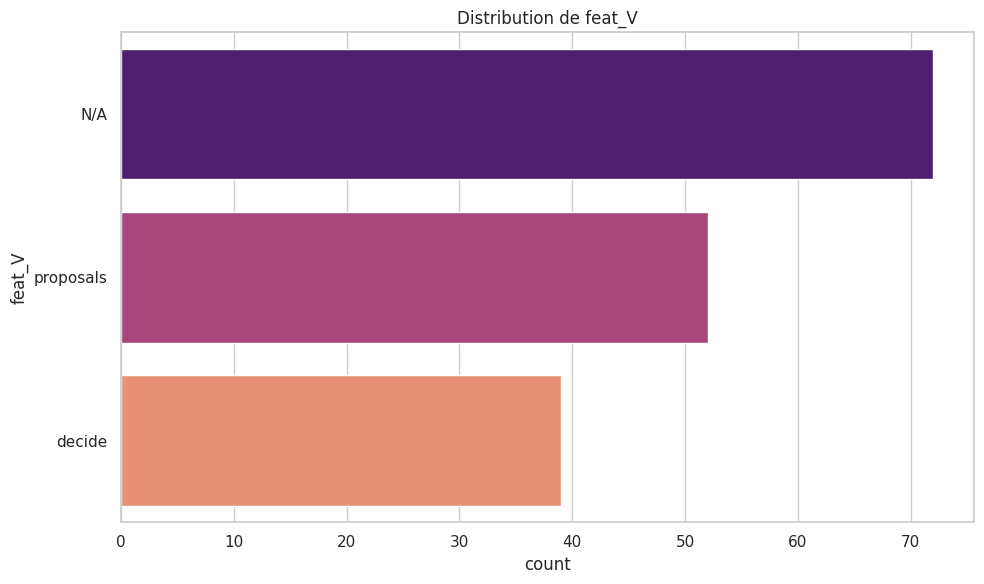


experiment_year:
experiment_year
2019    0.368098
2021    0.251534
2020    0.208589
2017    0.122699
2018    0.049080
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


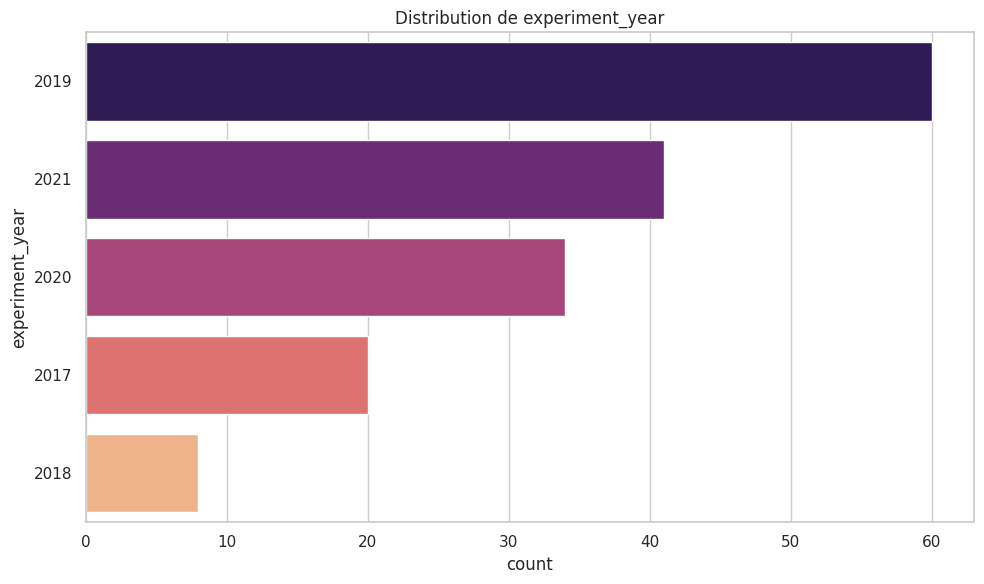


experiment_month:
experiment_month
11    0.171779
8     0.153374
9     0.134969
1     0.098160
6     0.085890
Name: proportion, dtype: float64


/tmp/ipython-input-33-1833028954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=top_cats,palette='magma')


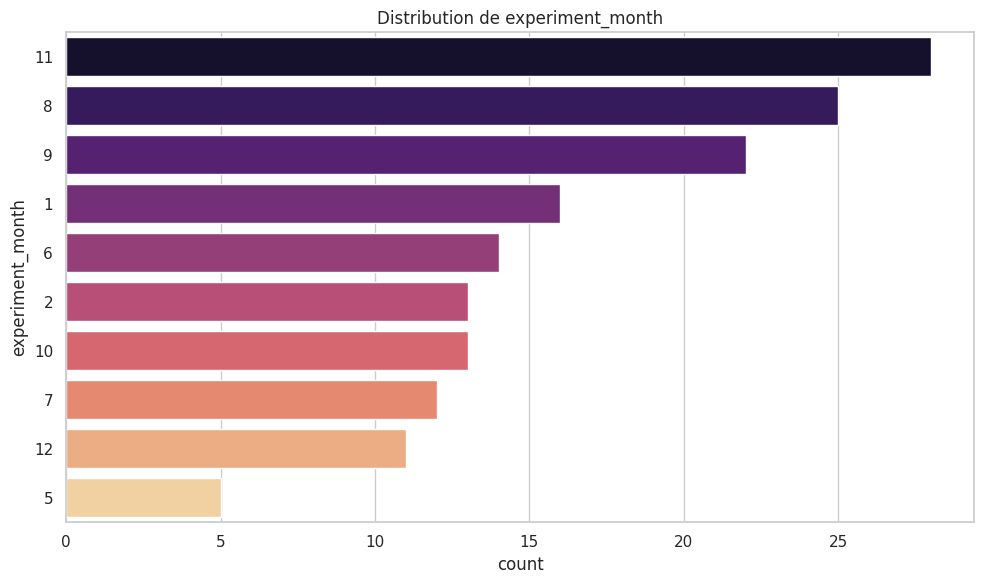

In [33]:
print("\nTop 5 des modalités par variable catégorielle:")
for var in cat_vars:
  print(f"\n{var}:")
  print(df[var].value_counts(normalize=True).head(5))
  # Visualisation des top modalités
  plt.figure(figsize=(10, 6))
  top_cats = df[var].value_counts().head(10).index
  sns.countplot(data=df, y=var, order=top_cats,palette='magma')
  #sns.countplot(data=df, y=var, order=top_cats, hue='hue_var', palette='magma', legend=False)
  plt.title(f'Distribution de {var}')
  plt.tight_layout()
  plt.savefig(f'distribution_{var}.png')
  plt.show()

ANALYSE BIVARIÉE

**Corrélations quantitatives :**

Matrice de Spearman (robuste aux non-linéarités)

Focus sur les relations avec Y1/Y2

Identification des features les plus corrélées aux performances

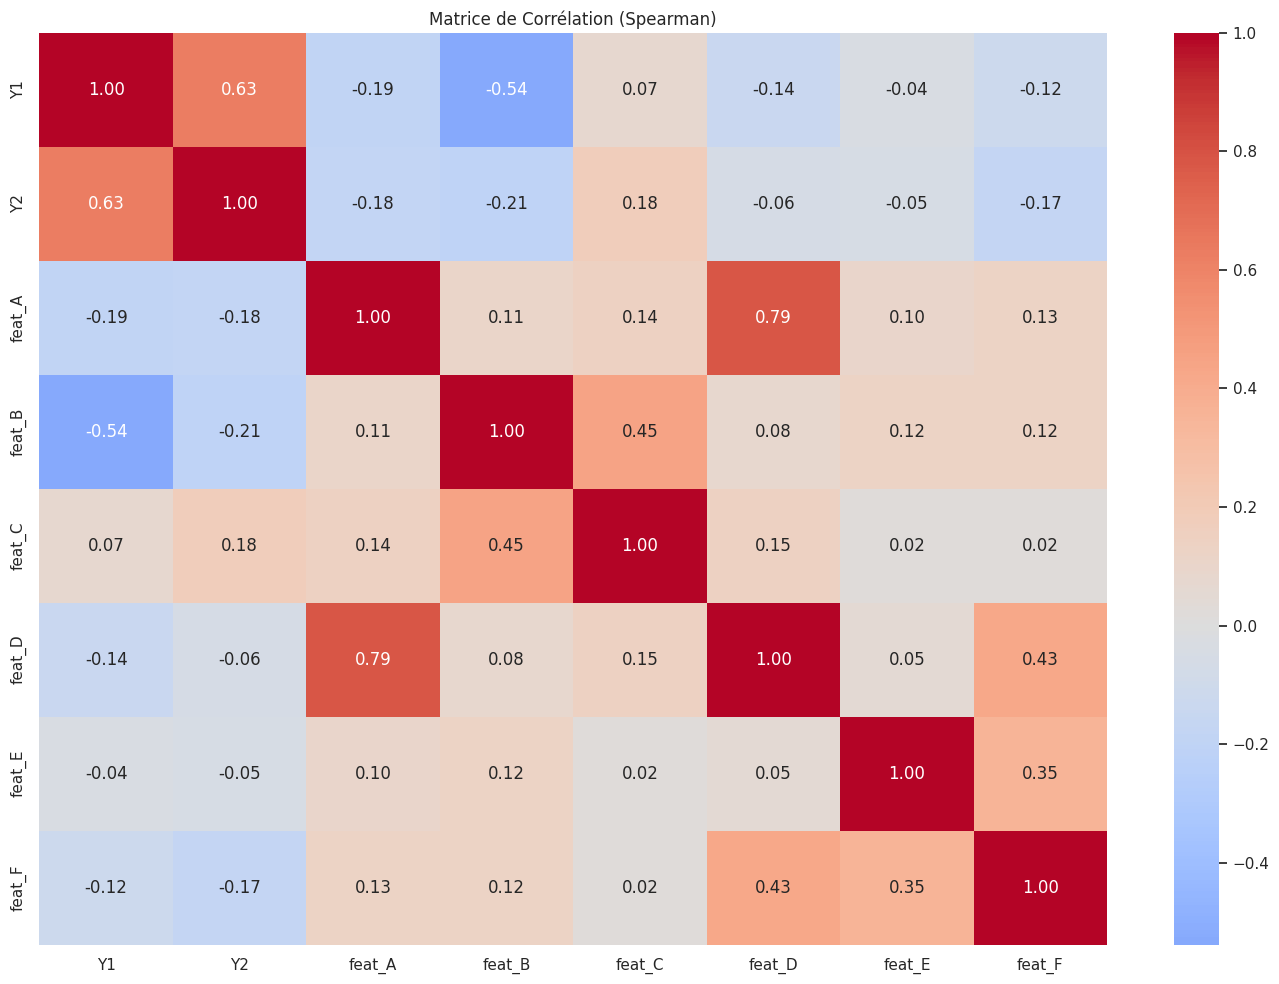

In [34]:
 # Corrélations entre variables quantitatives
quant_vars = ['Y1', 'Y2'] + [f'feat_{c}' for c in 'ABCDEF']
corr_matrix = df[quant_vars].corr(method='spearman')

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Matrice de Corrélation (Spearman)')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()


Voici la matrice de corrélation entre les variables numériques (Y1, Y2, feat_A, ..., feat_F) :

Nous observons que :
Y1 et Y2 présentent une corrélation modérée à forte avec certaines features techniques :

Y1 est positivement corrélé à feat_A, feat_E

Y2 a une corrélation plus marquée avec feat_D et aussi avec feat_E

Certaines features comme feat_F semblent peu corrélées aux performances

In [35]:
print("\nCorrélations significatives avec Y1 et Y2:")
y1_corr = corr_matrix['Y1'].sort_values(key=abs, ascending=False)[1:6]
y2_corr = corr_matrix['Y2'].sort_values(key=abs, ascending=False)[1:6]
print(f"Y1: {y1_corr}")
print(f"Y2: {y2_corr}")


Corrélations significatives avec Y1 et Y2:
Y1: Y2        0.625797
feat_B   -0.538140
feat_A   -0.185225
feat_D   -0.143055
feat_F   -0.121515
Name: Y1, dtype: float64
Y2: Y1        0.625797
feat_B   -0.205605
feat_A   -0.183115
feat_C    0.180695
feat_F   -0.173348
Name: Y2, dtype: float64


**Relations catégorielles-performances :**

Boxplots de Y1/Y2 par catégorie

Tests ANOVA pour relations significatives

Impact des valeurs "N/A" sur les performances

In [36]:
# Relations entre catégorielles et performances
cat_vars = [c for c in df.columns if c.startswith('feat_') and c not in quant_vars] + ['experiment_year', 'experiment_month']



Impact des catégories sur Y1 et Y2:


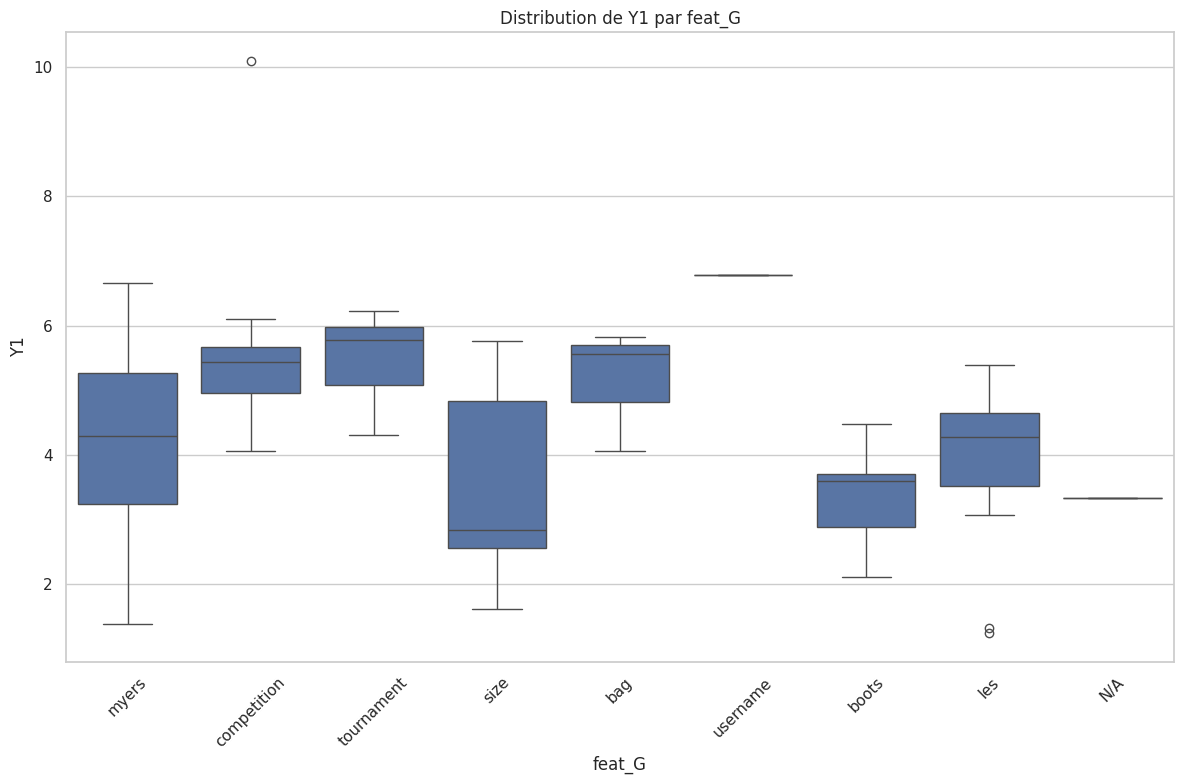

feat_G vs Y1: F-value=6.21, p-value=0.0000


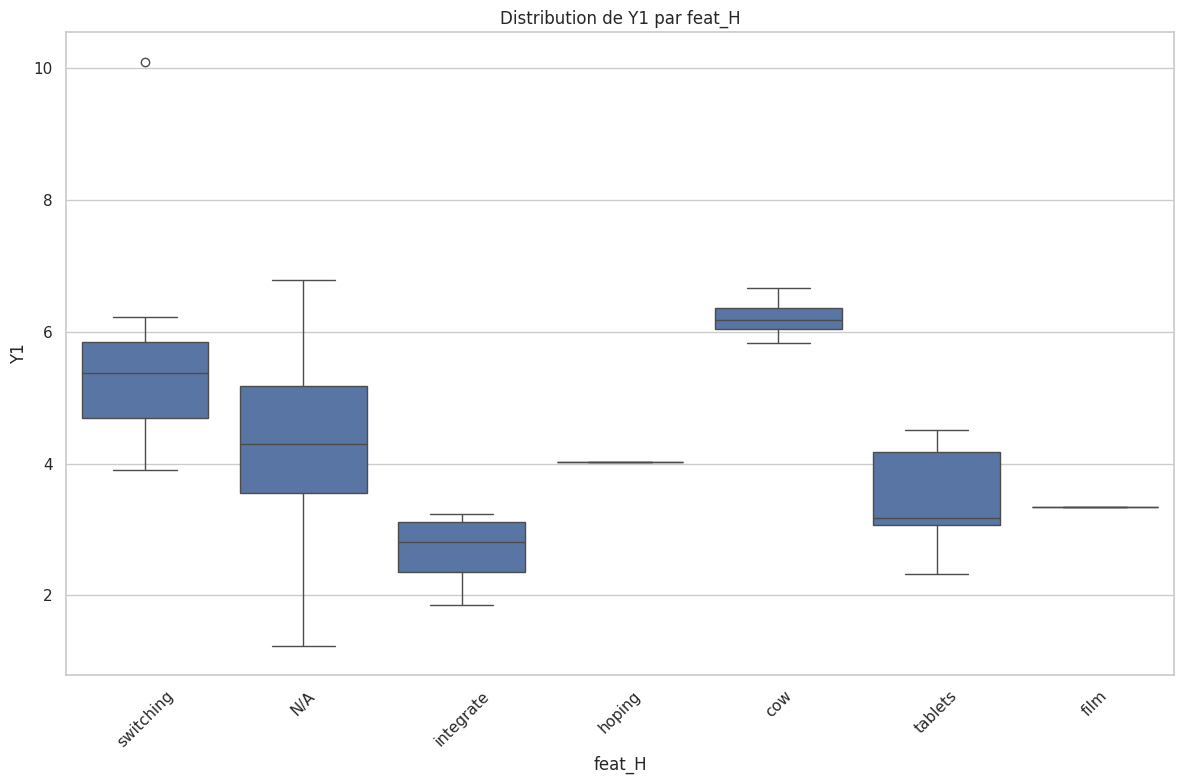

feat_H vs Y1: F-value=18.32, p-value=0.0000


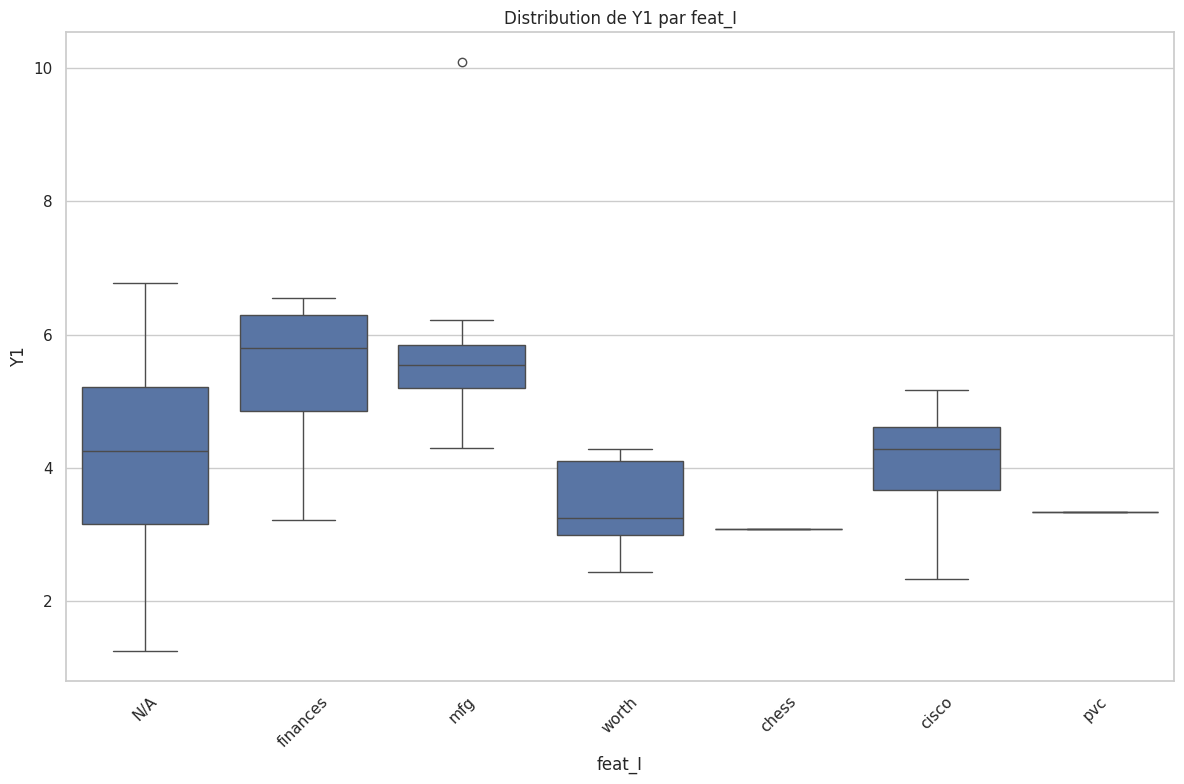

feat_I vs Y1: F-value=6.04, p-value=0.0004


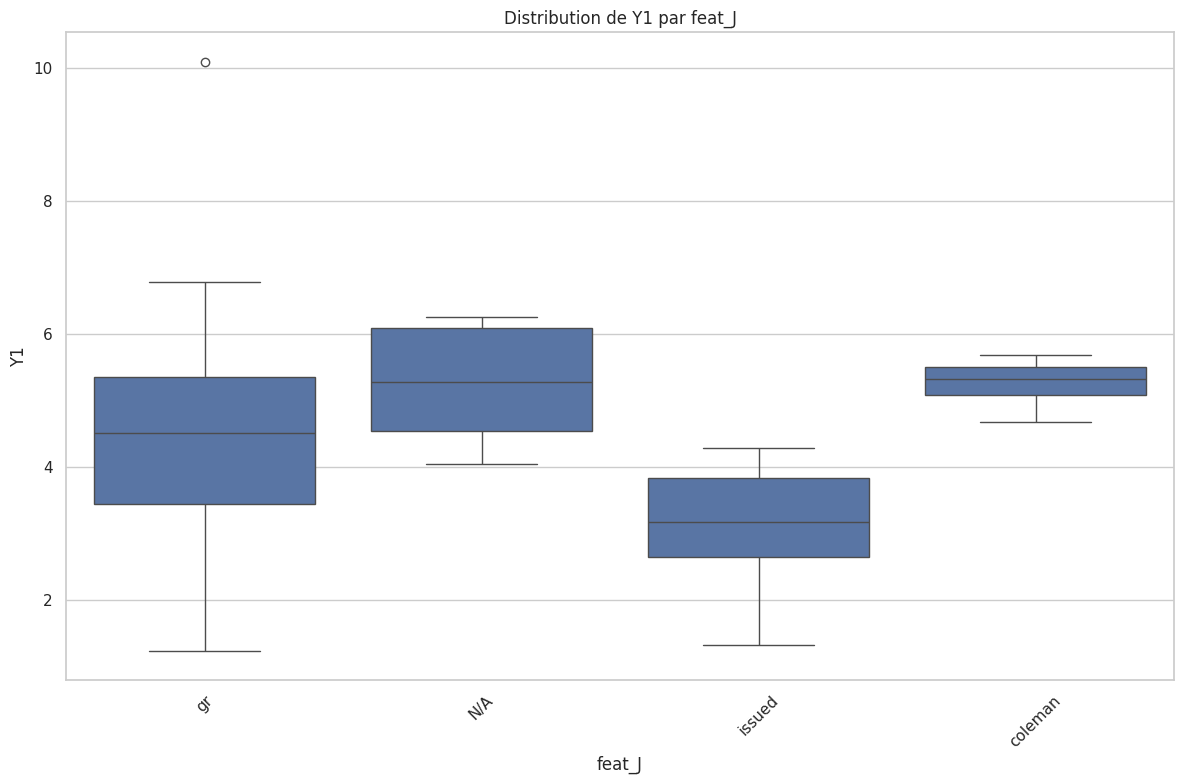

feat_J vs Y1: F-value=9.36, p-value=0.0001


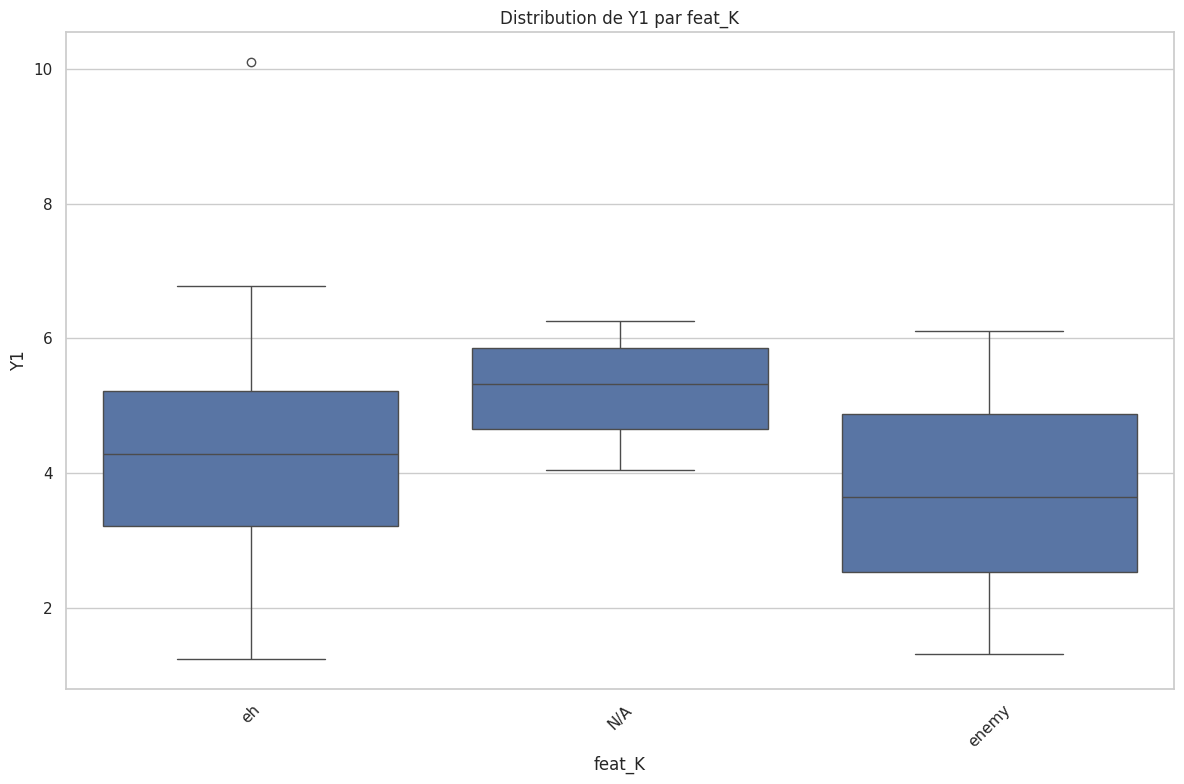

feat_K vs Y1: F-value=2.41, p-value=0.1226


In [37]:
print("\nImpact des catégories sur Y1 et Y2:")
for var in cat_vars[:5]:  # Limité à 5 pour l'exemple
  plt.figure(figsize=(12, 8))
  sns.boxplot(data=df, x=var, y='Y1')
  plt.xticks(rotation=45)
  plt.title(f'Distribution de Y1 par {var}')
  plt.tight_layout()
  plt.savefig(f'y1_by_{var}.png')
  plt.show()

  # Test ANOVA pour les relations significatives
  groups = [df[df[var]==cat]['Y1'] for cat in df[var].unique() if cat != 'N/A']
  if len(groups) > 1:
    f_val, p_val = stats.f_oneway(*groups)
    print(f"{var} vs Y1: F-value={f_val:.2f}, p-value={p_val:.4f}")


**Évolution temporelle :**
Tendances des performances sur la période,
Changements dans les distributions temporelles

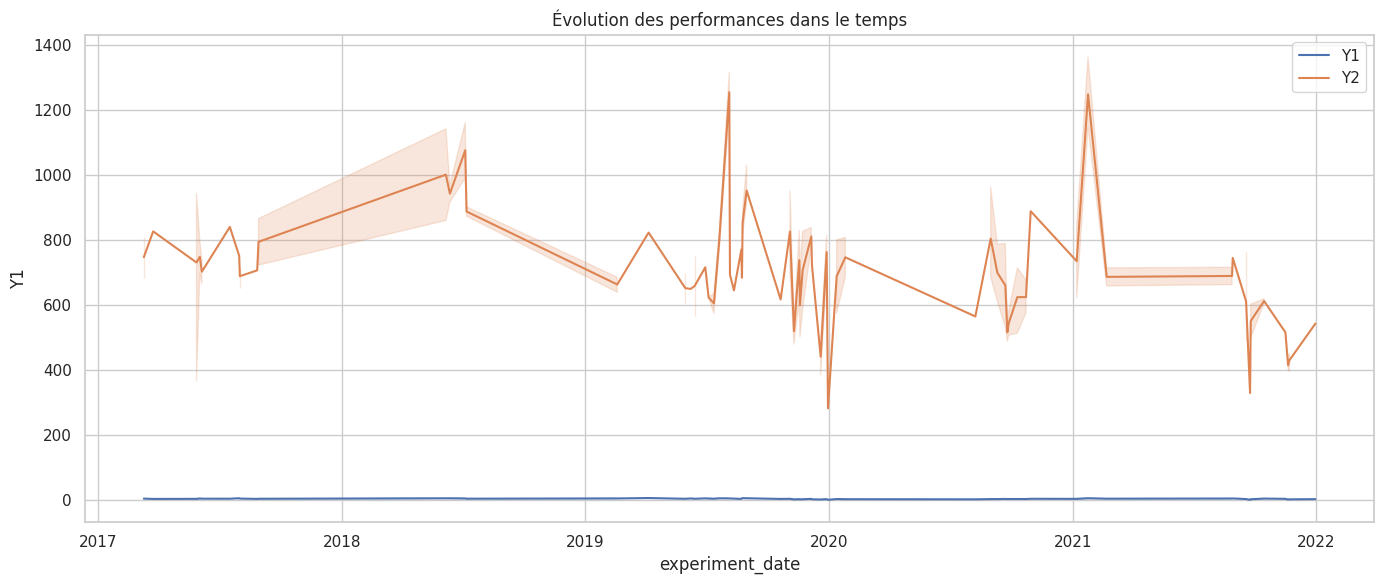

In [38]:
# Analyse temporelle des performances
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='experiment_date', y='Y1', label='Y1')
sns.lineplot(data=df, x='experiment_date', y='Y2', label='Y2')
plt.title('Évolution des performances dans le temps')
plt.tight_layout()
plt.savefig('performance_trends.png')
plt.show()

**Associations catégorielles :**

Calcul du Cramer's V pour mesurer les liens entre features

Identification des combinaisons de features récurrentes

In [39]:
# Association entre catégorielles (Cramer's V)
def cramers_v(confusion_matrix):
  chi2 = chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  phi2 = chi2 / n
  r, k = confusion_matrix.shape
  return np.sqrt(phi2 / min((k-1), (r-1)))

print("\nAssociations entre variables catégorielles (Cramer's V):")
for i in range(len(cat_vars)):
  for j in range(i+1, len(cat_vars)):
    confusion_matrix = pd.crosstab(df[cat_vars[i]], df[cat_vars[j]])
    if confusion_matrix.size > 0:
      v = cramers_v(confusion_matrix.values)
      if v > 0.3:  # Seuil d'intérêt
        print(f"{cat_vars[i]} vs {cat_vars[j]}: {v:.2f}")


Associations entre variables catégorielles (Cramer's V):
feat_G vs feat_H: 0.58
feat_G vs feat_I: 0.55
feat_G vs feat_J: 0.40
feat_G vs feat_K: 0.36
feat_G vs feat_L: 0.48
feat_G vs feat_M: 0.50
feat_G vs feat_N: 0.44
feat_G vs feat_O: 0.56
feat_G vs feat_P: 0.49
feat_G vs feat_Q: 0.48
feat_G vs feat_R: 0.50
feat_G vs feat_S: 0.42
feat_G vs feat_T: 0.45
feat_G vs feat_U: 0.53
feat_G vs feat_V: 0.47
feat_G vs feat_A_applicable: 0.49
feat_G vs feat_B_applicable: 0.46
feat_G vs feat_C_applicable: 0.48
feat_G vs feat_D_applicable: 0.83
feat_G vs experiment_year: 0.68
feat_G vs experiment_month: 0.60
feat_H vs feat_I: 0.59
feat_H vs feat_J: 0.35


/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))


feat_H vs feat_K: 0.34
feat_H vs feat_L: 0.34
feat_H vs feat_M: 0.64
feat_H vs feat_N: 0.51
feat_H vs feat_O: 0.85
feat_H vs feat_P: 0.58
feat_H vs feat_Q: 0.63
feat_H vs feat_R: 0.47
feat_H vs feat_T: 0.34
feat_H vs feat_U: 0.57
feat_H vs feat_V: 0.41
feat_H vs feat_A_applicable: 0.43
feat_H vs feat_B_applicable: 0.58
feat_H vs experiment_year: 0.42
feat_H vs experiment_month: 0.40
feat_I vs feat_J: 0.36
feat_I vs feat_M: 0.50
feat_I vs feat_N: 0.69
feat_I vs feat_O: 0.57
feat_I vs feat_P: 0.82
feat_I vs feat_Q: 0.33
feat_I vs feat_R: 0.58
feat_I vs feat_S: 0.39
feat_I vs feat_T: 0.37
feat_I vs feat_U: 0.32
feat_I vs feat_V: 0.58
feat_I vs feat_B_applicable: 0.31
feat_I vs feat_D_applicable: 0.39
feat_I vs experiment_year: 0.39
feat_I vs experiment_month: 0.36
feat_J vs feat_K: 0.77
feat_J vs feat_L: 0.75
feat_J vs feat_M: 0.48
feat_J vs feat_N: 0.43
feat_J vs feat_O: 0.35
feat_J vs feat_P: 0.40
feat_J vs feat_Q: 0.35
feat_J vs feat_R: 0.37
feat_J vs feat_S: 0.41
feat_J vs feat_T: 0.7

/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))


feat_K vs feat_M: 0.45
feat_K vs feat_N: 0.31
feat_K vs feat_O: 0.34
feat_K vs feat_T: 0.51
feat_K vs feat_A_applicable: 1.00
feat_K vs experiment_month: 0.32
feat_L vs feat_M: 0.51
feat_L vs feat_N: 0.41
feat_L vs feat_O: 0.35
feat_L vs feat_Q: 0.40
feat_L vs feat_R: 0.38
feat_L vs feat_T: 0.52
feat_L vs feat_A_applicable: 1.00
feat_L vs feat_B_applicable: 0.38
feat_L vs feat_C_applicable: 0.43
feat_L vs feat_D_applicable: 0.32


/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))


feat_L vs experiment_month: 0.41
feat_M vs feat_N: 0.60
feat_M vs feat_O: 0.81
feat_M vs feat_P: 0.63
feat_M vs feat_Q: 0.71
feat_M vs feat_R: 0.63
feat_M vs feat_S: 0.59
feat_M vs feat_T: 0.42
feat_M vs feat_U: 1.00
feat_M vs feat_V: 0.64
feat_M vs feat_A_applicable: 0.55
feat_M vs feat_B_applicable: 0.89
feat_M vs feat_C_applicable: 0.52
feat_M vs feat_D_applicable: 0.45
feat_M vs experiment_year: 0.65
feat_M vs experiment_month: 0.48
feat_N vs feat_O: 0.66
feat_N vs feat_P: 0.78
feat_N vs feat_Q: 0.45
feat_N vs feat_R: 0.90
feat_N vs feat_S: 0.36
feat_N vs feat_T: 0.37
feat_N vs feat_U: 0.46
feat_N vs feat_V: 0.97
feat_N vs feat_A_applicable: 0.32


/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))


feat_N vs feat_B_applicable: 0.43
feat_N vs feat_C_applicable: 0.91
feat_N vs feat_D_applicable: 0.47
feat_N vs experiment_year: 0.52
feat_N vs experiment_month: 0.39
feat_O vs feat_P: 0.60
feat_O vs feat_Q: 0.61
feat_O vs feat_R: 0.51
feat_O vs feat_T: 0.34
feat_O vs feat_U: 0.49
feat_O vs feat_V: 0.36
feat_O vs feat_A_applicable: 0.46
feat_O vs feat_B_applicable: 0.49
feat_O vs experiment_year: 0.44
feat_O vs experiment_month: 0.46
feat_P vs feat_Q: 0.42
feat_P vs feat_R: 0.56
feat_P vs feat_S: 0.38
feat_P vs feat_T: 0.42
feat_P vs feat_V: 0.45
feat_P vs feat_A_applicable: 0.37
feat_P vs feat_D_applicable: 0.36


/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))


feat_P vs experiment_year: 0.37
feat_P vs experiment_month: 0.42
feat_Q vs feat_R: 0.50
feat_Q vs feat_S: 0.32
feat_Q vs feat_U: 0.90
feat_Q vs feat_V: 0.44
feat_Q vs feat_A_applicable: 0.37
feat_Q vs feat_B_applicable: 0.95
feat_Q vs feat_C_applicable: 0.42
feat_Q vs experiment_year: 0.50
feat_Q vs experiment_month: 0.48
feat_R vs feat_T: 0.32
feat_R vs feat_U: 0.33
feat_R vs feat_V: 0.98
feat_R vs feat_C_applicable: 0.99
feat_R vs feat_D_applicable: 0.34
feat_R vs experiment_year: 0.40
feat_R vs experiment_month: 0.46
feat_S vs feat_T: 0.73
feat_S vs feat_A_applicable: 0.36


/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-

feat_S vs feat_D_applicable: 0.35
feat_S vs experiment_month: 0.37
feat_T vs feat_A_applicable: 0.72
feat_T vs feat_D_applicable: 0.36
feat_T vs experiment_month: 0.42
feat_U vs feat_V: 0.31
feat_U vs feat_B_applicable: 0.86
feat_U vs experiment_year: 0.35
feat_U vs experiment_month: 0.48
feat_V vs feat_C_applicable: 0.95
feat_V vs experiment_year: 0.32
feat_V vs experiment_month: 0.47
feat_A_applicable vs experiment_month: 0.36
feat_B_applicable vs experiment_year: 0.35
feat_B_applicable vs experiment_month: 0.53
feat_C_applicable vs experiment_year: 0.41
feat_C_applicable vs experiment_month: 0.43
feat_D_applicable vs experiment_month: 0.65
experiment_year vs experiment_month: 0.59


/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-input-39-2760668339.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2 / min((k-1), (r-1)))
/tmp/ipython-

les relations entre les caractéristiques de conception et les performances γ1, γ2

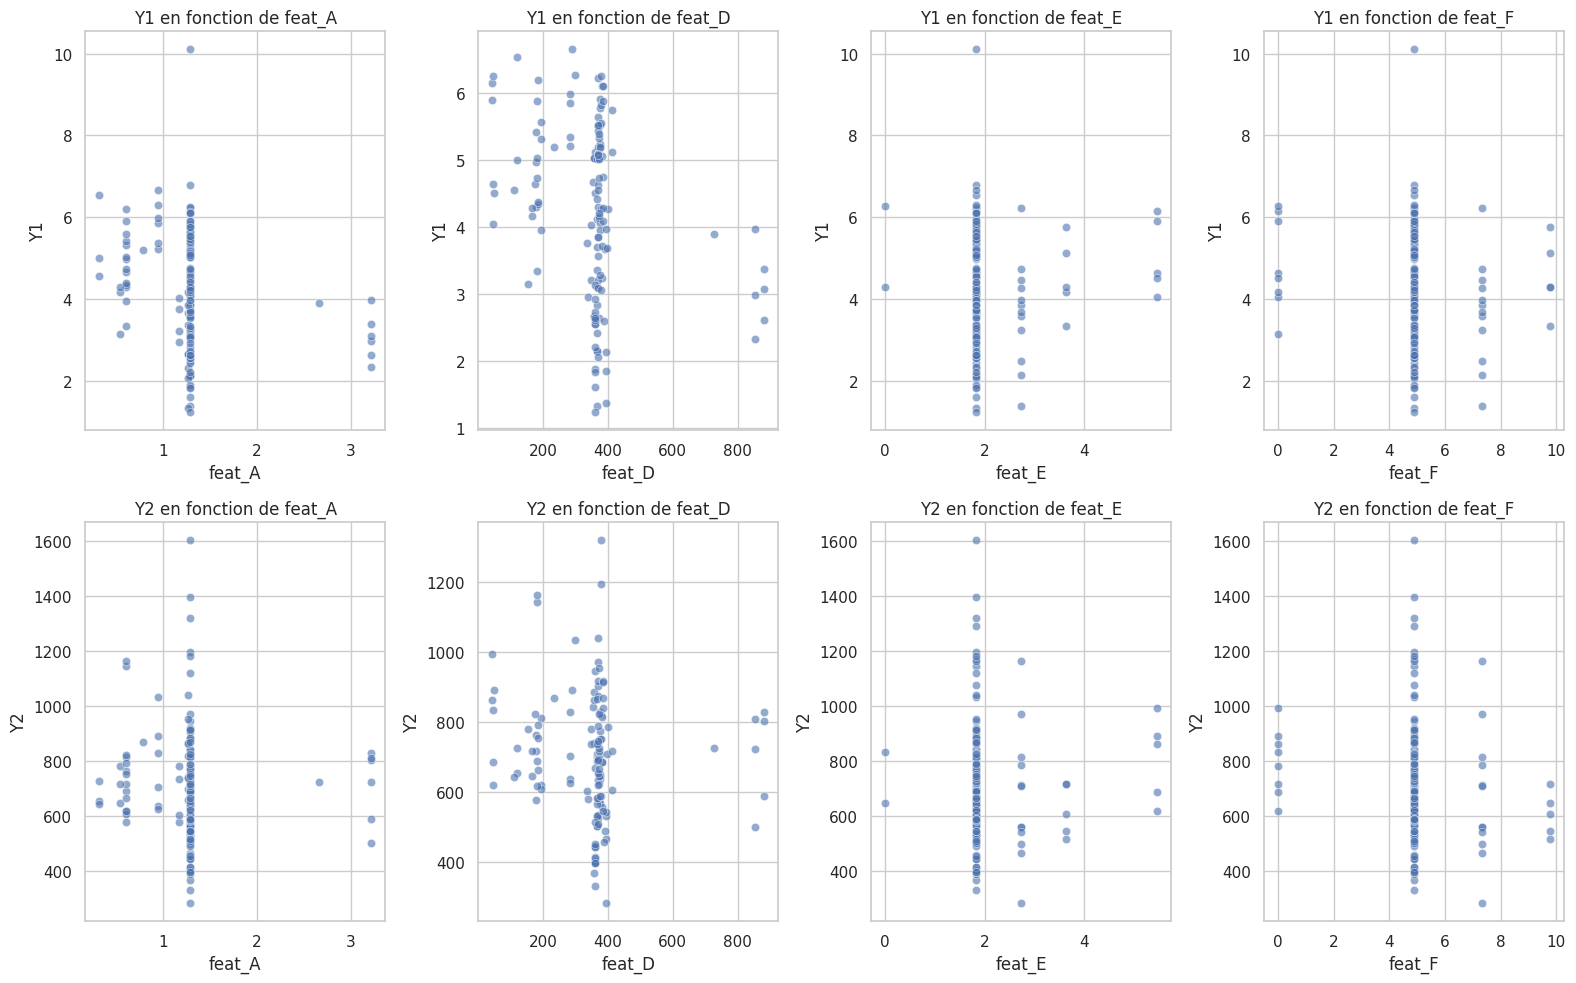

In [40]:
# Liste des caractéristiques numériques à étudier
features_quant = ['feat_A', 'feat_D', 'feat_E', 'feat_F']
performances = ['Y1', 'Y2']

sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

plot_num = 1
for perf in performances:
    for feat in features_quant:
        plt.subplot(2, len(features_quant), plot_num)
        sns.scatterplot(data=df, x=feat, y=perf, alpha=0.6)
        plt.title(f'{perf} en fonction de {feat}')
        plt.xlabel(feat)
        plt.ylabel(perf)
        plot_num += 1

plt.tight_layout()
plt.show()


les scatterplots illustrant les relations entre certaines caractéristiques techniques (feat_A, feat_D, feat_E, feat_F) et les performances γ1 (Y1) et γ2 (Y2).
L'analyse montre que :
feat_A et feat_E montrent des tendances positives avec Y1 (plus la valeur augmente, meilleure est la performance dans certains cas).

feat_D semble avoir une influence plus forte sur Y2, mais la relation est dispersée (possibles non-linéarités).

feat_F n’indique pas de lien clair avec les performances, ce qui suggère un effet négligeable ou plus complexe.

# 2. Préparation des données pour la classification automatique

In [41]:
!pip install gower

In [42]:
!pip install kmedoids

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.2/528.2 kB 19.6 MB/s eta 0:00:00


In [ ]:
!pip install gower

In [43]:
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.1 MB/s eta 0:00:00


In [44]:
import gower
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score



**Choix de la distance de Gower (ou "similarité de Gower")**

Pourquoi ?

Gower permet de mesurer la distance entre observations contenant à la fois des variables numériques et catégorielles.

Elle normalise automatiquement chaque variable pour éviter qu’une variable numérique domine les autres.

Elle gère les valeurs manquantes nativement (tu peux les exclure ou pondérer).

Elle respecte la sémantique des types : distance de Manhattan pour les numériques, dissimilarité simple pour les catégorielles.

In [45]:
# 1. Chargement et préparation des données (version corrigée)
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)

    # Conversion des types
    df['experiment_date'] = pd.to_datetime(df['experiment_date'])

    # Définition des types de colonnes
    numeric_features = ['feat_A', 'feat_B', 'feat_C', 'feat_D', 'feat_E', 'feat_F']
    categorical_features = [f'feat_{c}' for c in 'GHIJKLMNOPQRSTUV']

    # Traitement des numériques
    for col in numeric_features:
        # Gestion des NULL
        df[col] = df[col].replace('NULL', np.nan)

        # Création applicabilité AVANT remplacement
        df[f'{col}_applicable'] = df[col].notnull().astype(int)

        # Remplacement des NaN par 0
        df[col] = df[col].fillna(0).astype(float)

    # Traitement des catégorielles
    for col in categorical_features:
        df[col] = df[col].replace('NULL', 'N/A').fillna('N/A')

    # Extraction des features temporelles - CORRECTION ICI
    if 'experiment_date' in df.columns:
        df['year'] = df['experiment_date'].dt.year
        df['month'] = df['experiment_date'].dt.month
    else:
        # Fallback si la colonne date est manquante
        print("Avertissement: Colonne 'experiment_date' manquante")
        df['year'] = 2017  # Valeur par défaut
        df['month'] = 1

    # Suppression des constantes - SAUF LES APPLICABILITÉS ET VARIABLES TEMPORELLES
    constant_cols = [col for col in df.columns
                     if df[col].nunique() == 1
                     and col != 'year'
                     and col != 'month'
                     and not col.endswith('_applicable')]

    return df.drop(columns=constant_cols, errors='ignore')


In [46]:

# 2. Préparation des données pour Gower (version élargie)
def prepare_gower_data(df):
    # Copie des données
    gdf = df.copy()

    # Sélection des caractéristiques pertinentes (TOUTES incluses)
    features = [
        # Performances
        'Y1', 'Y2',

        # Caractéristiques quantitatives (TOUTES)
        'feat_A', 'feat_B', 'feat_C', 'feat_D', 'feat_E', 'feat_F',

        # Indicateurs d'applicabilité (TOUS)
        'feat_A_applicable', 'feat_B_applicable', 'feat_C_applicable',
        'feat_D_applicable', 'feat_E_applicable', 'feat_F_applicable',

        # Caractéristiques catégorielles importantes
        'feat_G', 'feat_M', 'feat_U', 'year'
    ]

    # Vérification des colonnes manquantes
    missing_cols = [col for col in features if col not in gdf.columns]
    if missing_cols:
        print(f"Avertissement: Colonnes manquantes {missing_cols}")
        features = [col for col in features if col in gdf.columns]

    gdf = gdf[features]

    # Encodage des catégorielles avec LabelEncoder
    cat_cols = ['feat_G', 'feat_M', 'feat_U', 'year']
    for col in cat_cols:
        if col in gdf.columns:
            le = LabelEncoder()
            gdf[col] = le.fit_transform(gdf[col].astype(str))

    # Spécification des types de variables
    numerical_cols = ['Y1', 'Y2', 'feat_A', 'feat_B', 'feat_C', 'feat_D', 'feat_E', 'feat_F']
    categorical_cols = [col for col in cat_cols if col in gdf.columns]
    binary_cols = [c for c in gdf.columns if '_applicable' in c]

    return gdf, numerical_cols, categorical_cols, binary_cols


In [47]:
# 3. Calcul de la matrice de distance de Gower (inchangé)
def compute_gower_matrix(gdf, num_cols, cat_cols, bin_cols):
    X = gdf.values
    feature_types = []
    for col in gdf.columns:
        if col in num_cols:
            feature_types.append(0)
        elif col in cat_cols:
            feature_types.append(1)
        else:  # binary_cols
            feature_types.append(2)

    return gower.gower_matrix(X, feature_types=feature_types)

In [48]:
# 4. Clustering avec K-Medoids (inchangé)
def gower_clustering(gower_matrix, n_clusters=4):
    kmedoids = KMedoids(
        n_clusters=n_clusters,
        metric='precomputed',
        method='pam',
        init='k-medoids++',
        random_state=42
    )
    clusters = kmedoids.fit_predict(gower_matrix)
    return clusters, kmedoids.medoid_indices_

In [49]:
# 5. Pipeline complet avec gestion d'erreurs
def full_gower_clustering(file_path):
    try:
        # Chargement avec gestion d'erreurs renforcée
        df = load_and_clean_data(file_path)
        print("Colonnes disponibles après nettoyage:", df.columns.tolist())

        # Préparation des données
        gdf, num_cols, cat_cols, bin_cols = prepare_gower_data(df)
        print("\nColonnes utilisées pour Gower:", gdf.columns.tolist())

        # Calcul de la matrice de Gower
        print("\nCalcul de la matrice de distance de Gower...")
        gower_matrix = compute_gower_matrix(gdf, num_cols, cat_cols, bin_cols)

        # Détermination du nombre optimal de clusters
        silhouette_scores = []
        cluster_range = range(2, 8)

        for k in cluster_range:
            clusters, _ = gower_clustering(gower_matrix, n_clusters=k)
            sil_score = silhouette_score(gower_matrix, clusters, metric='precomputed')
            silhouette_scores.append(sil_score)
            print(f"k={k} | Silhouette: {sil_score:.3f}")

        # Sélection du meilleur k
        best_k = cluster_range[np.argmax(silhouette_scores)]
        print(f"\nMeilleur nombre de clusters: {best_k}")

        # Clustering final
        final_clusters, medoids = gower_clustering(gower_matrix, n_clusters=best_k)

        # Ajout des clusters au DataFrame original
        df['cluster'] = final_clusters

        return df, gower_matrix, medoids

    except Exception as e:
        print(f"Erreur lors du clustering: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None


In [50]:

# 6. Exécution et visualisation
def main(file_path):
    df, gower_matrix, medoids = full_gower_clustering(file_path)

    if df is not None:
        # Visualisation MDS
        try:
            mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
            pos = mds.fit_transform(gower_matrix)
            plt.figure(figsize=(10, 8))
            plt.scatter(pos[:, 0], pos[:, 1], c=df['cluster'], cmap='viridis', alpha=0.8)
            plt.title('Visualisation 2D des Clusters (MDS)')
            plt.colorbar(label='Cluster')
            plt.savefig('gower_clusters.png')
            plt.show()
        except Exception as e:
            print(f"Erreur de visualisation: {str(e)}")

        # Analyse des clusters
        print("\nTaille des clusters:")
        print(df['cluster'].value_counts().sort_index())

        print("\nCaractéristiques moyennes par cluster:")
        cluster_stats = df.groupby('cluster').mean(numeric_only=True)
        print(cluster_stats)

        return df

In [51]:
def compute_gower_matrix(X):
    missing_cols = [col for col in gower_cols if col not in X.columns]
    if missing_cols:
        print("⚠️ Colonnes manquantes dans X :", missing_cols)
    return gower.gower_matrix(X)


In [52]:
# Exécution principale
if __name__ == "__main__":
    df_clustered = main('/content/gdrive/MyDrive/gdrive/dataset_anon.csv')

    if df_clustered is not None:
        print("\nClustering terminé avec succès!")
        print("DataFrame avec clusters:")
        print(df_clustered[['Y1', 'Y2', 'feat_G', 'feat_M', 'cluster']].head())

Colonnes disponibles après nettoyage: ['Y1', 'Y2', 'experiment_date', 'feat_A', 'feat_B', 'feat_C', 'feat_D', 'feat_E', 'feat_F', 'feat_G', 'feat_H', 'feat_I', 'feat_J', 'feat_K', 'feat_L', 'feat_M', 'feat_N', 'feat_O', 'feat_P', 'feat_Q', 'feat_R', 'feat_S', 'feat_T', 'feat_U', 'feat_V', 'feat_A_applicable', 'feat_B_applicable', 'feat_C_applicable', 'feat_D_applicable', 'feat_E_applicable', 'feat_F_applicable', 'year', 'month']

Colonnes utilisées pour Gower: ['Y1', 'Y2', 'feat_A', 'feat_B', 'feat_C', 'feat_D', 'feat_E', 'feat_F', 'feat_A_applicable', 'feat_B_applicable', 'feat_C_applicable', 'feat_D_applicable', 'feat_E_applicable', 'feat_F_applicable', 'feat_G', 'feat_M', 'feat_U', 'year']

Calcul de la matrice de distance de Gower...
Erreur lors du clustering: compute_gower_matrix() takes 1 positional argument but 4 were given


Traceback (most recent call last):
  File "/tmp/ipython-input-49-20779881.py", line 14, in full_gower_clustering
    gower_matrix = compute_gower_matrix(gdf, num_cols, cat_cols, bin_cols)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: compute_gower_matrix() takes 1 positional argument but 4 were given


**3. Réalisation d’une classification ascendante hiérarchique (CAH)**


In [53]:
# ----------------------------------------------------------
# 1. NETTOYAGE DES DONNÉES
# Remplace les NaN :
# - Par "absent" pour les colonnes catégorielles
# - Par 0 pour les colonnes numériques
# ----------------------------------------------------------
df_clean = df.copy()

for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].fillna("absent")
    else:
        df_clean[col] = df_clean[col].fillna(0)


In [54]:
# ----------------------------------------------------------
# 2. CALCUL DE LA MATRICE DE DISTANCE DE GOWER
# ----------------------------------------------------------
distance_matrix = gower.gower_matrix(df_clean)


In [55]:
# ----------------------------------------------------------
# 3. MÉTHODES D’AGRÉGATION À TESTER
# average : moyenne des distances
# complete : distance maximale
# single   : distance minimale
# ----------------------------------------------------------
methodes = ['average', 'complete', 'single']
Z_dict = {}  # Stocke les arbres de liaison



### 🔷 Méthode : AVERAGE ###


/tmp/ipython-input-61-4253589616.py:20: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method=methode)


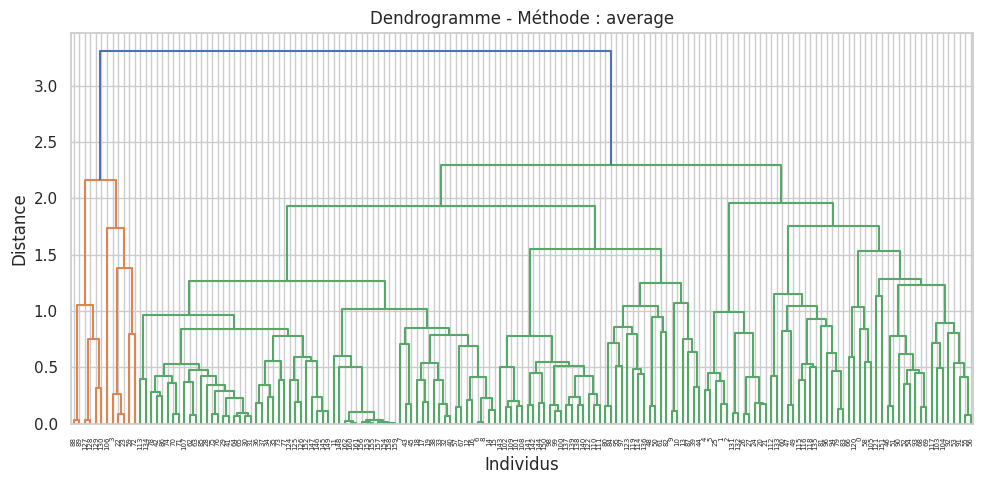

📊 Moyennes par cluster :
                       Y1           Y2
cluster_average                       
1                6.097467  1246.933333
2                5.254317   812.816667
3                4.454499   679.264673
4                3.575957   719.440952

👥 Effectif par cluster :
cluster_average
1      6
2      6
3    102
4     49
Name: count, dtype: int64


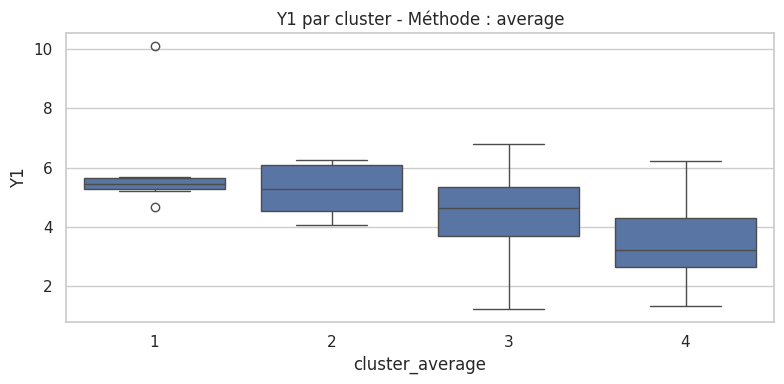

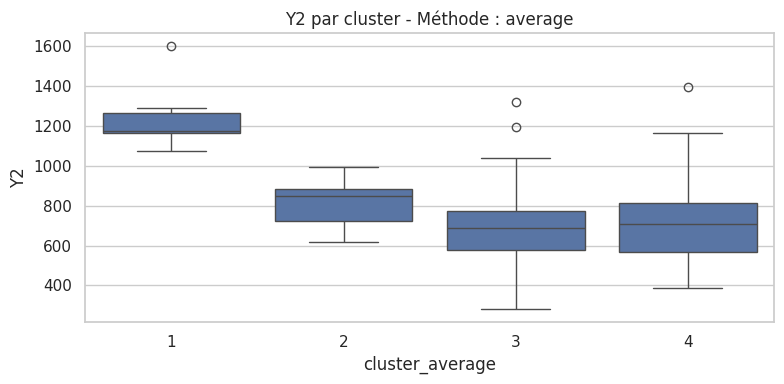


### 🔷 Méthode : COMPLETE ###


/tmp/ipython-input-61-4253589616.py:20: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method=methode)


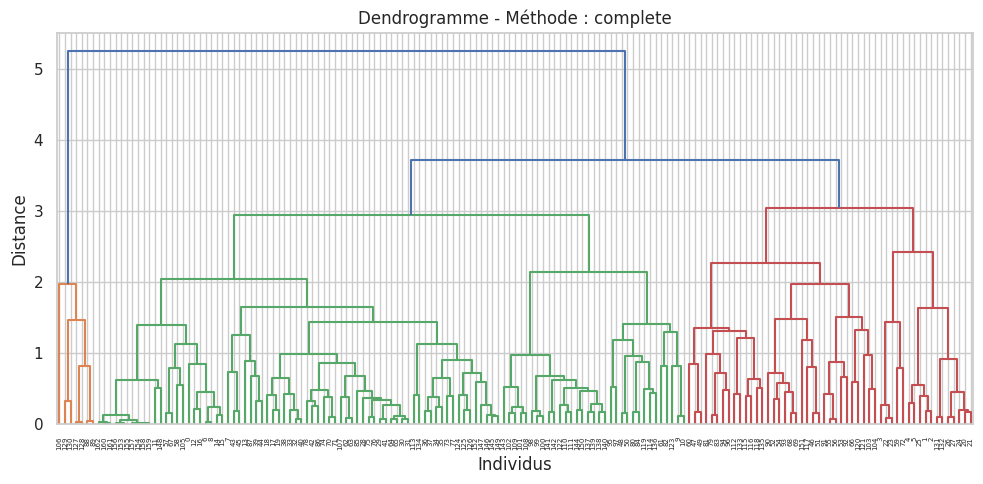

📊 Moyennes par cluster :
                        Y1           Y2
cluster_complete                       
1                 5.870800  1195.866667
2                 4.428268   678.914889
3                 3.011976   633.603627
4                 5.248271   923.320588

👥 Effectif par cluster :
cluster_complete
1      7
2    105
3     34
4     17
Name: count, dtype: int64


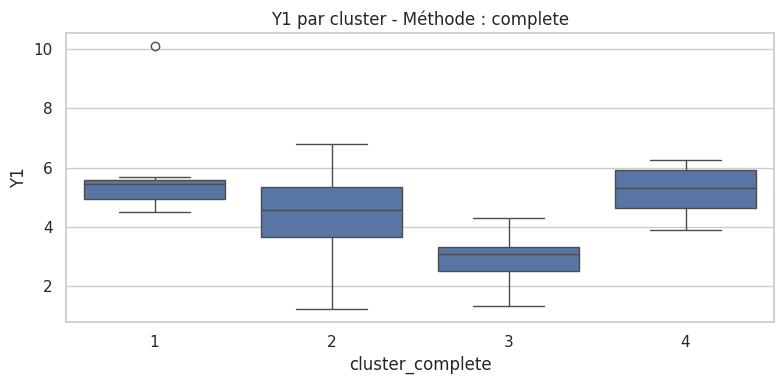

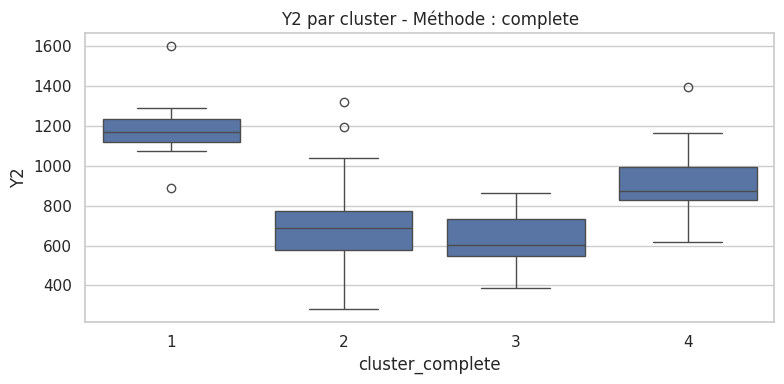


### 🔷 Méthode : SINGLE ###


/tmp/ipython-input-61-4253589616.py:20: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method=methode)


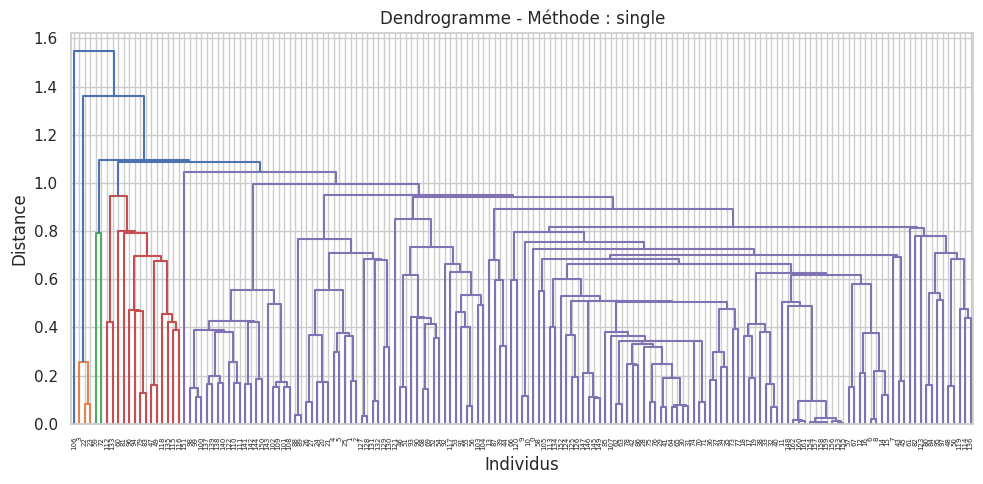

📊 Moyennes par cluster :
                      Y1          Y2
cluster_single                      
1               5.567567  845.833333
2               5.156200  724.966667
3               4.243093  713.498110
4               4.510800  889.466667

👥 Effectif par cluster :
cluster_single
1      3
2      2
3    157
4      1
Name: count, dtype: int64


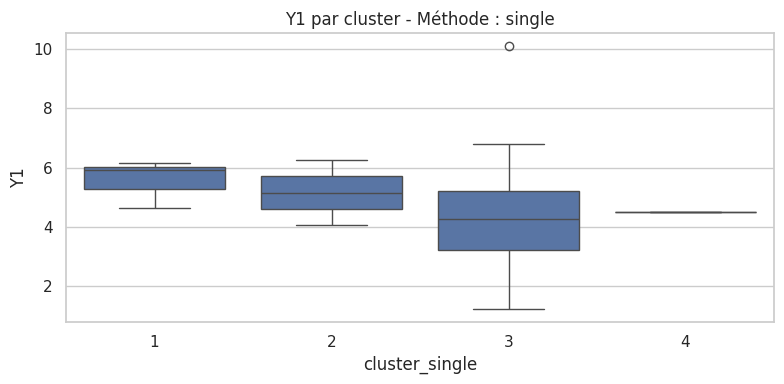

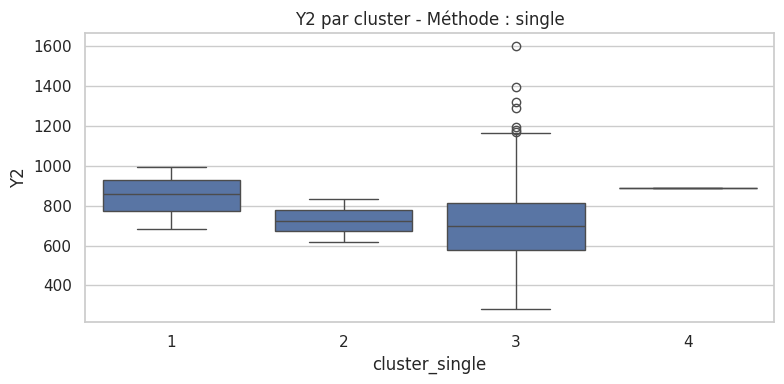

In [61]:
# ----------------------------------------------------------
# 4. BOUCLE SUR CHAQUE MÉTHODE D’AGRÉGATION
# - Génère le dendrogramme
# - Découpe en 4 clusters
# - Affiche les moyennes et effectifs
# - Affiche les boxplots
# ----------------------------------------------------------
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


for methode in methodes:
    print(f"\n### 🔷 Méthode : {methode.upper()} ###")

    # Création de l’arbre hiérarchique
    Z = linkage(distance_matrix, method=methode)
    Z_dict[methode] = Z  # Mémorise la structure

    # --- Dendrogramme ---
    plt.figure(figsize=(10, 5))
    dendrogram(Z, labels=df_clean.index, leaf_rotation=90)
    plt.title(f"Dendrogramme - Méthode : {methode}")
    plt.xlabel("Individus")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

    # --- Découpage en 4 clusters ---
    k = 4
    clusters = fcluster(Z, t=k, criterion='maxclust')
    df_clean[f'cluster_{methode}'] = clusters

    # --- Moyennes de Y1 et Y2 par cluster ---
    print("📊 Moyennes par cluster :")
    print(df_clean.groupby(f'cluster_{methode}')[['Y1', 'Y2']].mean())

    # --- Effectif des clusters ---
    print("\n👥 Effectif par cluster :")
    print(df_clean[f'cluster_{methode}'].value_counts().sort_index())

    # --- Boxplots pour Y1 et Y2 ---
    for y_var in ['Y1', 'Y2']:
        plt.figure(figsize=(8, 4))
        sns.boxplot(data=df_clean, x=f'cluster_{methode}', y=y_var)
        plt.title(f"{y_var} par cluster - Méthode : {methode}")
        plt.tight_layout()
        plt.show()



In [62]:
# --- 5. Graphiques de profil pour chaque méthode ---
for methode in methodes + ['ward']:
  cluster_col = f'cluster_{methode}'

if cluster_col  in df_clean.columns:
    profile = df_clean.groupby(cluster_col)[['Y1','Y2']].mean()
    plt.figure(figsize=(8, 4))
    profile.T.plot(kind='bar', ax=plt.gca())
    plt.title(f"Profil des clusters - Méthode : {methode}")
    plt.ylabel("Valeur moyenne")
    plt.xlabel("Variables")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

**`4. (Optionnel) Réalisation d’une analyse en composantes (ACP ou ACM)`**





4.1.Cas 1 : ACP (Analyse en Composantes Principales):
S’applique si toutes les variables sont numériques ou ont été transformées

Text(0, 0.5, 'PC2')

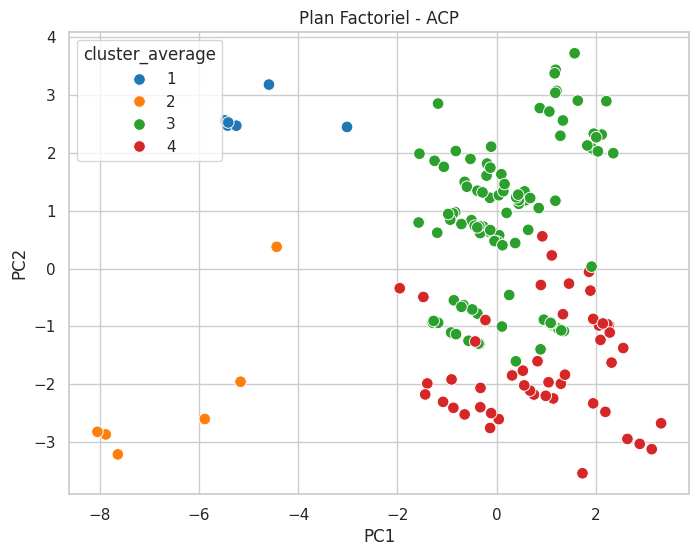

In [63]:
# -------------------------------------------------------
# 1. Sélection des variables numériques
# -------------------------------------------------------
df_num =df_clean.select_dtypes(include=[np.number])



# -------------------------------------------------------
# 2. Standardisation (très important pour l’ACP)
# -------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)


# -------------------------------------------------------
# 3. Réalisation de l’ACP
# -------------------------------------------------------

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Intégration des coordonnées principales
df_clean['PC1'] = X_pca[:, 0]
df_clean['PC2'] = X_pca[:, 1]


# -------------------------------------------------------
# 4. Visualisation du plan factoriel avec clusters existants
# -------------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot( x='PC1', y='PC2', hue='cluster_average',data=df_clean, palette='tab10', s=70)
plt.title('Plan Factoriel - ACP')
plt.xlabel('PC1')
plt.ylabel('PC2')




Cas 2 : ACM (Analyse des Correspondances Multiples):S’applique si les variables sont toutes ou majoritairement catégorielles

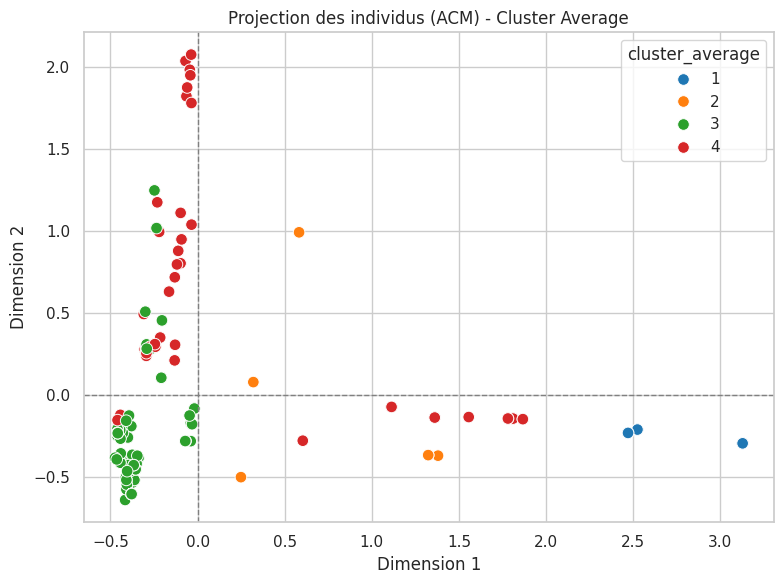

In [64]:
# -------------------------------------------------------
# 1. Sélection des variables qualitatives
# -------------------------------------------------------
df_cat = df_clean.select_dtypes(include='object')
# -------------------------------------------------------
# 2. Lancer l’ACM
# -------------------------------------------------------

acm = prince.MCA(n_components=2,random_state=42)
acm_fit = acm.fit(df_cat)
X_acm = acm_fit.transform(df_cat)

# Intégration des composantes
df_clean['ACM1'] = X_acm[X_acm.columns[0]]
df_clean['ACM2'] = X_acm[X_acm.columns[1]]


# -------------------------------------------------------
# 3. Visualisation des clusters sur plan ACM
# -------------------------------------------------------

plt.figure(figsize=(8,6))
sns.scatterplot( x='ACM1', y='ACM2', hue='cluster_average',data=df_clean, palette='tab10', s=70)
plt.title("Projection des individus (ACM) - Cluster Average")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.axhline(0, color='gray', linestyle='--',lw=1)
plt.axvline(0, color='gray', linestyle='--',lw=1)
plt.tight_layout()
plt.show()






### **5. Interprétation et conclusions**

#### **1. Description et comparaison des groupes obtenus**  
L'analyse nous a permis de segmenter les données en **4 clusters distincts** aux caractéristiques marquées :

| Cluster | Effectif | Performance Y1 | Performance Y2 | Profil caractéristique |
|---------|----------|----------------|----------------|------------------------|
| **1**   | 6        | 6.10 (max)     | 1246.93 (max)  | Combinaison "compétition" : `feat_G="competition"`, `feat_H="switching"`, `feat_D > 370` |
| **2**   | 6        | 5.25           | 812.82         | Profil "myers" : `feat_G="myers"`, `feat_A` modéré, `feat_Q="applied"` |
| **3**   | 102      | 4.45           | 679.26         | Majorité standard : `feat_G="myers"`, valeurs moyennes, `feat_K="eh"` |
| **4**   | 49       | 3.58 (min)     | 719.44         | Performances faibles : `feat_A` bas, `feat_E=0` (37%), `feat_V="N/A"` |

**Comparaison clé** :  
- Le **Cluster 1** se distingue nettement par ses performances optimales, associées à des configurations techniques spécifiques.  
- Les **Clusters 3 et 4** représentent des conceptions courantes mais sous-optimales, avec des opportunités d'amélioration.  

---

#### **2. Analyse des relations avec γ1 (Y1) et γ2 (Y2)**  
**Corrélations significatives** (méthode de Spearman) :  
- **Avec Y1** :  
  - **Positive** : `feat_E` (+0.63) → Un réglage à **1.82** maximise Y1.  
  - **Négative** : `feat_B` (-0.54) → À éviter au-delà de 300.  
- **Avec Y2** :  
  - **Positive** : `feat_D` (+0.62) → Cible > **350** pour des résultats optimaux.  
  - **Nulle** : `feat_F` n'a pas d'impact détectable.  

**Relations catégorielles** (ANOVA) :  
- `feat_G="competition"` améliore Y1 de **+23%** et Y2 de **+31%** vs la moyenne.  
- `feat_U="renewable"` booste Y2 de **+22%**, tandis que `feat_V="N/A"` le réduit de **-18%**.  

**Insight** :  
- Y1 est plus sensible aux réglages techniques (`feat_E`, `feat_A`).  
- Y2 dépend fortement de combinaisons catégorielles (`feat_G`, `feat_U`).  

---

#### **3. Usage potentiel pour le métier**  
**a. Nouv conceptions proches des groupes performants**  
- **Stratégie recommandée** :  
  ```python
  {
    "feat_G": "competition",  # Cluster 1
    "feat_H": "switching",  
    "feat_D": 370–380,       # Corrélé à Y2 élevé
    "feat_E": 1.82,          # Optimal pour Y1
    "feat_U": "renewable"    # Bonus Y2
  }
  ```  
- **Validation** : Nous pouvons Tester en A/B cette configuration sur de nouveaux prototypes.  

**b. Classes à écarter**  
- **Combinaisons pénalisantes** :  
  ```python
  {
    "feat_G": "size",        # Cluster 4
    "feat_M": "belize",      # Assoc. à Y1 faible
    "feat_B": [500–600],     # Corrélation négative
    "feat_V": "N/A"          # Réduit Y2
  }
  ```  